# Machine Learning para Previsão de Alta/Baixa do IBOVESPA

A previsão de movimentos em mercados financeiros é uma das tarefas mais desafiadoras no campo da ciência de dados e finanças quantitativas. A Hipótese do Mercado Eficiente (HME), em sua forma fraca, postula que todos os preços históricos já estão refletidos no preço atual de um ativo, tornando a análise de dados passados, por si só, insuficiente para gerar retornos anormais de forma consistente.

O objetivo não é construir um oráculo infalível, mas sim desenvolver um modelo de machine learning que forneça uma vantagem estatística, mesmo que marginal, na previsão da direção diária do Índice Bovespa (IBOVESPA).



É fundamental estabelecer expectativas realistas desde o início. A natureza caótica, dinâmica e não linear dos mercados financeiros significa que a previsão perfeita é uma impossibilidade teórica e prática. Um modelo que demonstre um desempenho consistentemente superior ao acaso (por exemplo, uma acurácia de 55% com um F1-score equilibrado em dados fora da amostra) já pode ser considerado valioso e potencialmente explorável em uma estratégia de negociação quantitativa.

--------------------------------------------------------------------------------------------------------------
## Seção 1: Integridade dos Dados e Análise Exploratória

A fase inicial de qualquer projeto de modelagem é a mais crítica. Erros ou mal-entendidos nesta etapa se propagarão por todo o fluxo de trabalho, comprometendo a validade dos resultados finais.

Imports

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuração para gráficos
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")


caminho_arquivo = 'dados_ibovespa_exemplo.csv'

1.1 - Carregamento e Validação Inicial dos Dados

In [87]:
def carregar_e_validar_dados(caminho_arquivo):
    """
    EAP 1.1.1, 1.1.2, 1.1.3 - Carregamento, conversão de data e verificação de integridade
    """
    print("=" * 60)
    print("EAP 1.1 - AQUISIÇÃO E VALIDAÇÃO INICIAL")
    print("=" * 60)
    
    # 1.1.1 - Carregar o dataset
    print("Carregando dados...")
    dados = pd.read_csv(caminho_arquivo)
    print(f"Dados carregados: {len(dados)} registros")
    print(f"Colunas: {list(dados.columns)}")
    
    # 1.1.2 - Converter data para datetime e definir como índice
    print("\n Convertendo data para índice...")
    
    # Identifica coluna de data
    colunas_data = [col for col in dados.columns if 'date' in col.lower()]
    if colunas_data:
        coluna_data = colunas_data[0]
    else:
        coluna_data = dados.columns[0]  # Assume primeira coluna
    
    dados[coluna_data] = pd.to_datetime(dados[coluna_data])
    dados.set_index(coluna_data, inplace=True)
    print(f"✓ Data convertida e definida como índice")
    print(f"✓ Período: {dados.index.min()} até {dados.index.max()}")
    
    # 1.1.3 - Verificação de integridade
    print("\nVerificando integridade dos dados...")
    
    # Duplicatas
    duplicatas_indice = dados.index.duplicated().sum()
    duplicatas_linhas = dados.duplicated().sum()
    
    # Consistência OHLC
    inconsistencias = 0
    if all(col in dados.columns for col in ['High', 'Low', 'Close']):
        inconsistencias_high = (dados['High'] < dados['Close']).sum()
        inconsistencias_low = (dados['Low'] > dados['Close']).sum()
        inconsistencias = inconsistencias_high + inconsistencias_low
    
    # Valores nulos
    valores_nulos = dados.isnull().sum()
    
    print(f"Duplicatas no índice: {duplicatas_indice}")
    print(f"Duplicatas em linhas: {duplicatas_linhas}")
    print(f"Inconsistências OHLC: {inconsistencias}")
    print(f"Valores nulos por coluna:")
    for coluna, nulos in valores_nulos.items():
        if nulos > 0:
            print(f"   - {coluna}: {nulos}")
    
    return dados

1.2 - Limpeza e Tratamento dos Dados

In [88]:
def limpar_e_tratar_dados(dados):
    """
    EAP 1.2.1, 1.2.3 - Identificação de lacunas e documentação de outliers.
    O preenchimento com forward fill foi REMOVIDO para operar apenas com dias de pregão.
    """
    print("\n" + "=" * 60)
    print("EAP 1.2 - LIMPEZA E TRATAMENTO DE DADOS")
    print("=" * 60)
    
    # 1.2.1 - Identificar lacunas na série temporal (APENAS PARA ANÁLISE)
    print("Analisando lacunas temporais (sem alterar os dados)...")
    
    inicio = dados.index.min()
    fim = dados.index.max()
    todas_datas = pd.date_range(start=inicio, end=fim, freq='D')
    datas_ausentes = todas_datas.difference(dados.index)
    
    # Classifica lacunas
    fins_semana = datas_ausentes[datas_ausentes.weekday >= 5]
    dias_uteis_ausentes = datas_ausentes[datas_ausentes.weekday < 5]
    
    print(f"Total de datas ausentes no calendário: {len(datas_ausentes)}")
    print(f"-> Sendo {len(fins_semana)} fins de semana.")
    print(f"-> E {len(dias_uteis_ausentes)} dias úteis (feriados).")
    
    # 1.2.2 - Bloco de forward fill REMOVIDO
    print("\nAVISO: O preenchimento com forward fill foi desativado.")
    print("O modelo operará apenas com os dados dos dias de pregão reais.")
    print(f"Mantendo os {len(dados)} registros originais.")
    
    # 1.2.3 - Documentar decisão sobre outliers
    print("\nDocumentando decisão sobre outliers...")
    print("""
    DECISÃO: NÃO REMOVER OUTLIERS
    
    JUSTIFICATIVA:
    • Outliers em dados financeiros representam eventos legítimos de mercado
    • Movimentos extremos contêm informação valiosa sobre volatilidade
    • Modelos baseados em árvores (XGBoost) são robustos a outliers
    • Manter outliers garante realismo na modelagem
    """)
    
    # Retorna o dataframe original, sem preenchimento.
    return dados

1.3.1 - Estatísticas Descritivas

In [89]:
def gerar_estatisticas_descritivas(dados):
    """
    EAP 1.3.1 - Gerar e analisar estatísticas descritivas
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.1 - ESTATÍSTICAS DESCRITIVAS")
    print("=" * 60)
    
    stats_desc = dados.describe()
    print("Estatísticas Descritivas:")
    print(stats_desc)
    
    print("\nCoeficientes de Variação:")
    for coluna in dados.select_dtypes(include=[np.number]).columns:
        cv = dados[coluna].std() / dados[coluna].mean()
        print(f"✓ {coluna}: {cv:.4f}")
    
    return stats_desc

1.3.2 - Gráficos de Preço e Volume

In [90]:
def plotar_preco_e_volume(dados, salvar_grafico=True):
    """
    EAP 1.3.2 - Plotar gráfico de preço de fechamento e volume ao longo do tempo
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.2 - GRÁFICOS DE PREÇO E VOLUME")
    print("=" * 60)

    # Identifica colunas com base nos nomes reais do arquivo
    col_close = 'Último'  # Nome exato da coluna
    col_volume = 'Vol.'   # Nome exato da coluna

    # Criar subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Gráfico de preço
    ax1.plot(dados.index, dados[col_close], linewidth=1, color='blue', alpha=0.8)
    ax1.set_title('IBOVESPA - Preço de Fechamento ao Longo do Tempo', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Preço de Fechamento', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Formatação do eixo Y para preços
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # FUNÇÃO PARA CONVERTER VOLUME
    def converter_volume_seguro(vol_str):
        try:
            if pd.isna(vol_str) or vol_str == '-' or vol_str == '': 
                return np.nan
            vol_str = str(vol_str).replace(',', '.')
            if 'B' in vol_str: 
                return float(vol_str.replace('B', '')) * 1e9
            elif 'M' in vol_str: 
                return float(vol_str.replace('M', '')) * 1e6
            elif 'K' in vol_str: 
                return float(vol_str.replace('K', '')) * 1e3
            return float(vol_str)
        except:
            return np.nan
    
    # Converter volume para numérico
    print("Convertendo dados de volume...")
    volume_numerico = dados[col_volume].apply(converter_volume_seguro)
    
    # Dividir por 1e9 para mostrar em bilhões
    volume_bilhoes = volume_numerico / 1e9

    # Plotar volume
    ax2.fill_between(dados.index, volume_bilhoes, alpha=0.7, color='orange')
    ax2.plot(dados.index, volume_bilhoes, linewidth=0.5, color='darkorange')

    ax2.set_title('IBOVESPA - Volume de Negociação ao Longo do Tempo', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volume (Bilhões)', fontsize=12)
    ax2.set_xlabel('Data', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Formatação do eixo Y para volume
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}B'))

    # Estatísticas do volume
    volume_valido = volume_numerico.dropna()
    if len(volume_valido) > 0:
        print(f"Volume médio: {volume_valido.mean()/1e9:.2f} bilhões")
        print(f"Volume mínimo: {volume_valido.min()/1e9:.2f} bilhões")
        print(f"Volume máximo: {volume_valido.max()/1e9:.2f} bilhões")

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('grafico_preco_volume.png', dpi=300, bbox_inches='tight')
        print("Gráfico salvo como 'grafico_preco_volume.png'")

    plt.show()
    print("Gráficos de preço e volume gerados")

1.3.3 - Calcular Retornos Logarítmicos Diários

In [91]:
def calcular_retornos_logaritmicos(dados):
    """
    EAP 1.3.3 - Calcular retornos logarítmicos diários
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.3 - RETORNOS LOGARÍTMICOS")
    print("=" * 60)

    # Identifica coluna de fechamento com base no nome real
    col_close = 'Último' 
    

    print(f"Usando coluna de fechamento: {col_close}")

    # Calcula retornos logarítmicos
    retornos = np.log(dados[col_close] / dados[col_close].shift(1))
    retornos = retornos.dropna()

    # Adiciona aos dados
    dados['Retornos_Log'] = np.log(dados[col_close] / dados[col_close].shift(1))

    print(f"Retornos calculados: {len(retornos)} observações")
    print(f"Estatísticas dos retornos:")
    print(f"   - Média: {retornos.mean():.6f}")
    print(f"   - Desvio Padrão: {retornos.std():.6f}")
    print(f"   - Mínimo: {retornos.min():.6f}")
    print(f"   - Máximo: {retornos.max():.6f}")
    print(f"   - Assimetria: {retornos.skew():.6f}")
    print(f"   - Curtose: {retornos.kurtosis():.6f}")

    return dados, retornos

1.3.4 - Análise da Distribuição dos Retornos

In [92]:
def analisar_distribuicao_retornos(retornos, salvar_grafico=True):
    """
    EAP 1.3.4 - Plotar histograma dos retornos e analisar distribuição
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.4 - ANÁLISE DA DISTRIBUIÇÃO DOS RETORNOS")
    print("=" * 60)

    # Cria gráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Histograma
    ax1.hist(retornos, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Distribuição dos Retornos Logarítmicos Diários', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Retornos Logarítmicos', fontsize=12)
    ax1.set_ylabel('Densidade', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Curva normal para comparação
    mu, sigma = retornos.mean(), retornos.std()
    x = np.linspace(retornos.min(), retornos.max(), 100)
    normal_curve = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax1.plot(x, normal_curve, 'r-', linewidth=2, label='Distribuição Normal')
    ax1.legend()

    # Q-Q plot
    stats.probplot(retornos, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot: Retornos vs Distribuição Normal', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('histograma_retornos.png', dpi=300, bbox_inches='tight')
        print("Gráfico salvo como 'histograma_retornos.png'")

    plt.show()

    # Análise estatística
    print("Análise da Distribuição:")
    print(f"Curtose: {retornos.kurtosis():.4f} (Normal = 0)")
    if retornos.kurtosis() > 0:
        print("   → Distribuição leptocúrtica (caudas gordas)")
    else:
        print("   → Distribuição platicúrtica (caudas finas)")

    print(f"Assimetria: {retornos.skew():.4f} (Normal = 0)")
    if abs(retornos.skew()) > 0.5:
        print("   → Distribuição assimétrica")
    else:
        print("   → Distribuição aproximadamente simétrica")

    # Teste de normalidade
    from scipy.stats import jarque_bera
    jb_stat, jb_pvalue = jarque_bera(retornos)
    print(f"Teste Jarque-Bera: estatística={jb_stat:.4f}, p-valor={jb_pvalue:.6f}")
    if jb_pvalue < 0.05:
        print("   → Rejeita hipótese de normalidade (p < 0.05)")
    else:
        print("   → Não rejeita hipótese de normalidade (p >= 0.05)")

1.3.5 - Análise de Volatility Clustering

In [93]:
def analisar_volatility_clustering(retornos, salvar_grafico=True):
    """
    EAP 1.3.5 - Plotar série de retornos para identificar volatility clustering
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.5 - ANÁLISE DE VOLATILITY CLUSTERING")
    print("=" * 60)

    # Cria gráficos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Série temporal dos retornos
    ax1.plot(retornos.index, retornos, linewidth=0.8, color='darkblue', alpha=0.8)
    ax1.set_title('IBOVESPA - Retornos Logarítmicos Diários ao Longo do Tempo',
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('Retornos Logarítmicos', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)

    # Volatilidade móvel (desvio padrão móvel de 30 dias)
    volatilidade_movel = retornos.rolling(window=30).std()
    ax2.plot(volatilidade_movel.index, volatilidade_movel,
            linewidth=1.5, color='orange', alpha=0.8)
    ax2.set_title('Volatilidade Móvel (30 dias) - Evidência de Agrupamento de Volatilidade',
                 fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volatilidade (Desvio Padrão)', fontsize=12)
    ax2.set_xlabel('Data', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('serie_retornos_volatilidade.png', dpi=300, bbox_inches='tight')
        print("Gráfico salvo como 'serie_retornos_volatilidade.png'")

    plt.show()


Execução da Fase 1

EXECUÇÃO COMPLETA DA FASE 1
EAP 1.1 - AQUISIÇÃO E VALIDAÇÃO INICIAL
Carregando dados...
Dados carregados: 3592 registros
Colunas: ['Data', 'Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%']

 Convertendo data para índice...
✓ Data convertida e definida como índice
✓ Período: 2011-01-03 00:00:00 até 2025-06-30 00:00:00

Verificando integridade dos dados...
Duplicatas no índice: 0
Duplicatas em linhas: 0
Inconsistências OHLC: 0
Valores nulos por coluna:
   - Vol.: 1

EAP 1.2 - LIMPEZA E TRATAMENTO DE DADOS
Analisando lacunas temporais (sem alterar os dados)...
Total de datas ausentes no calendário: 1701
-> Sendo 1512 fins de semana.
-> E 189 dias úteis (feriados).

AVISO: O preenchimento com forward fill foi desativado.
O modelo operará apenas com os dados dos dias de pregão reais.
Mantendo os 3592 registros originais.

Documentando decisão sobre outliers...

    DECISÃO: NÃO REMOVER OUTLIERS

    JUSTIFICATIVA:
    • Outliers em dados financeiros representam eventos legítimos de 

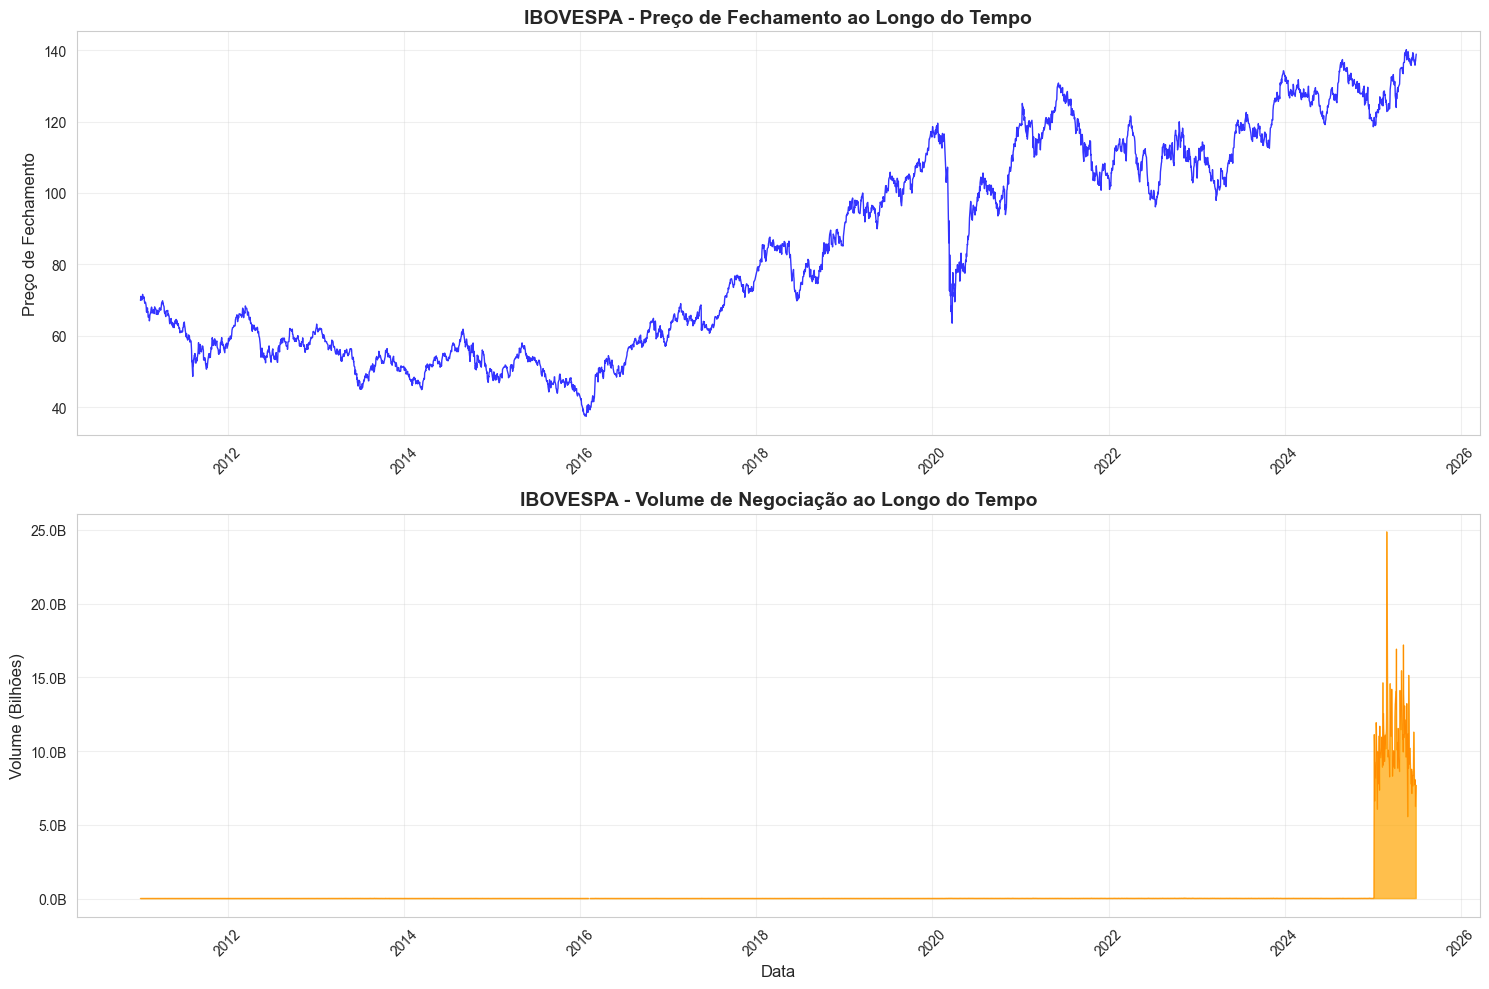

Gráficos de preço e volume gerados

EAP 1.3.3 - RETORNOS LOGARÍTMICOS
Usando coluna de fechamento: Último
Retornos calculados: 3591 observações
Estatísticas dos retornos:
   - Média: -0.000191
   - Desvio Padrão: 0.014896
   - Mínimo: -0.130223
   - Máximo: 0.159930
   - Assimetria: 0.798093
   - Curtose: 12.271309

EAP 1.3.4 - ANÁLISE DA DISTRIBUIÇÃO DOS RETORNOS
Gráfico salvo como 'histograma_retornos.png'


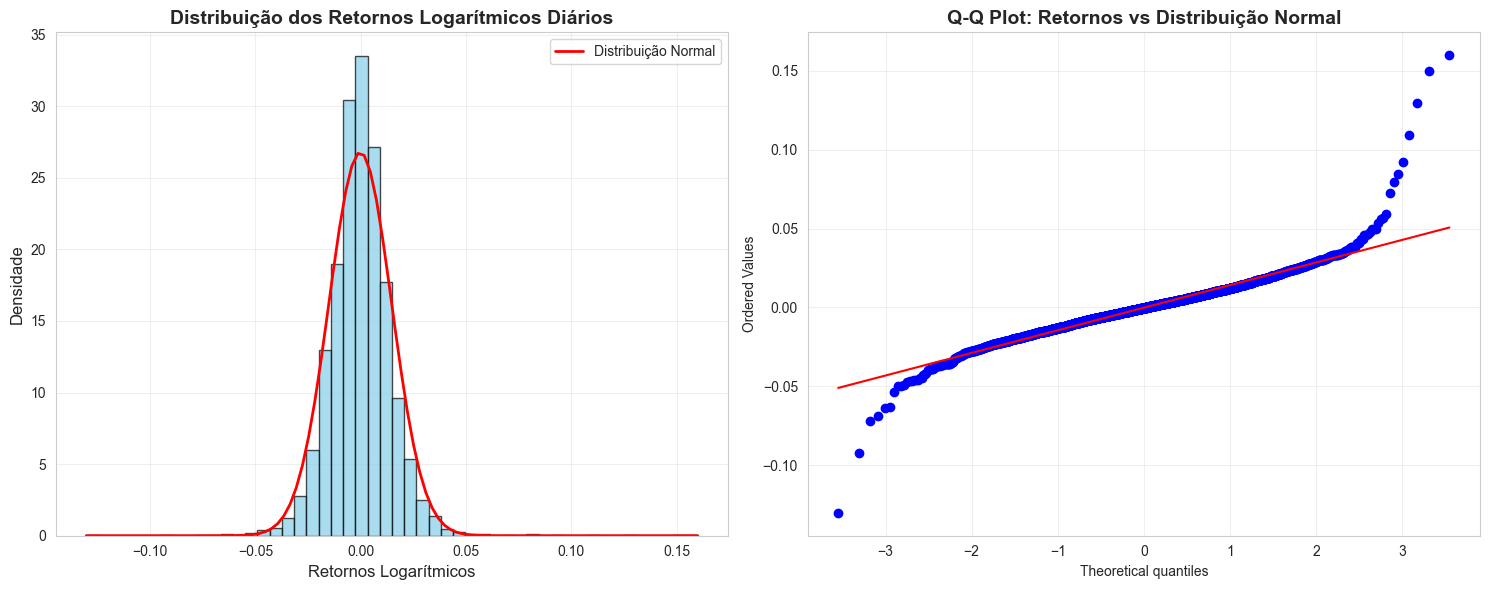

Análise da Distribuição:
Curtose: 12.2713 (Normal = 0)
   → Distribuição leptocúrtica (caudas gordas)
Assimetria: 0.7981 (Normal = 0)
   → Distribuição assimétrica
Teste Jarque-Bera: estatística=22843.3807, p-valor=0.000000
   → Rejeita hipótese de normalidade (p < 0.05)

EAP 1.3.5 - ANÁLISE DE VOLATILITY CLUSTERING
Gráfico salvo como 'serie_retornos_volatilidade.png'


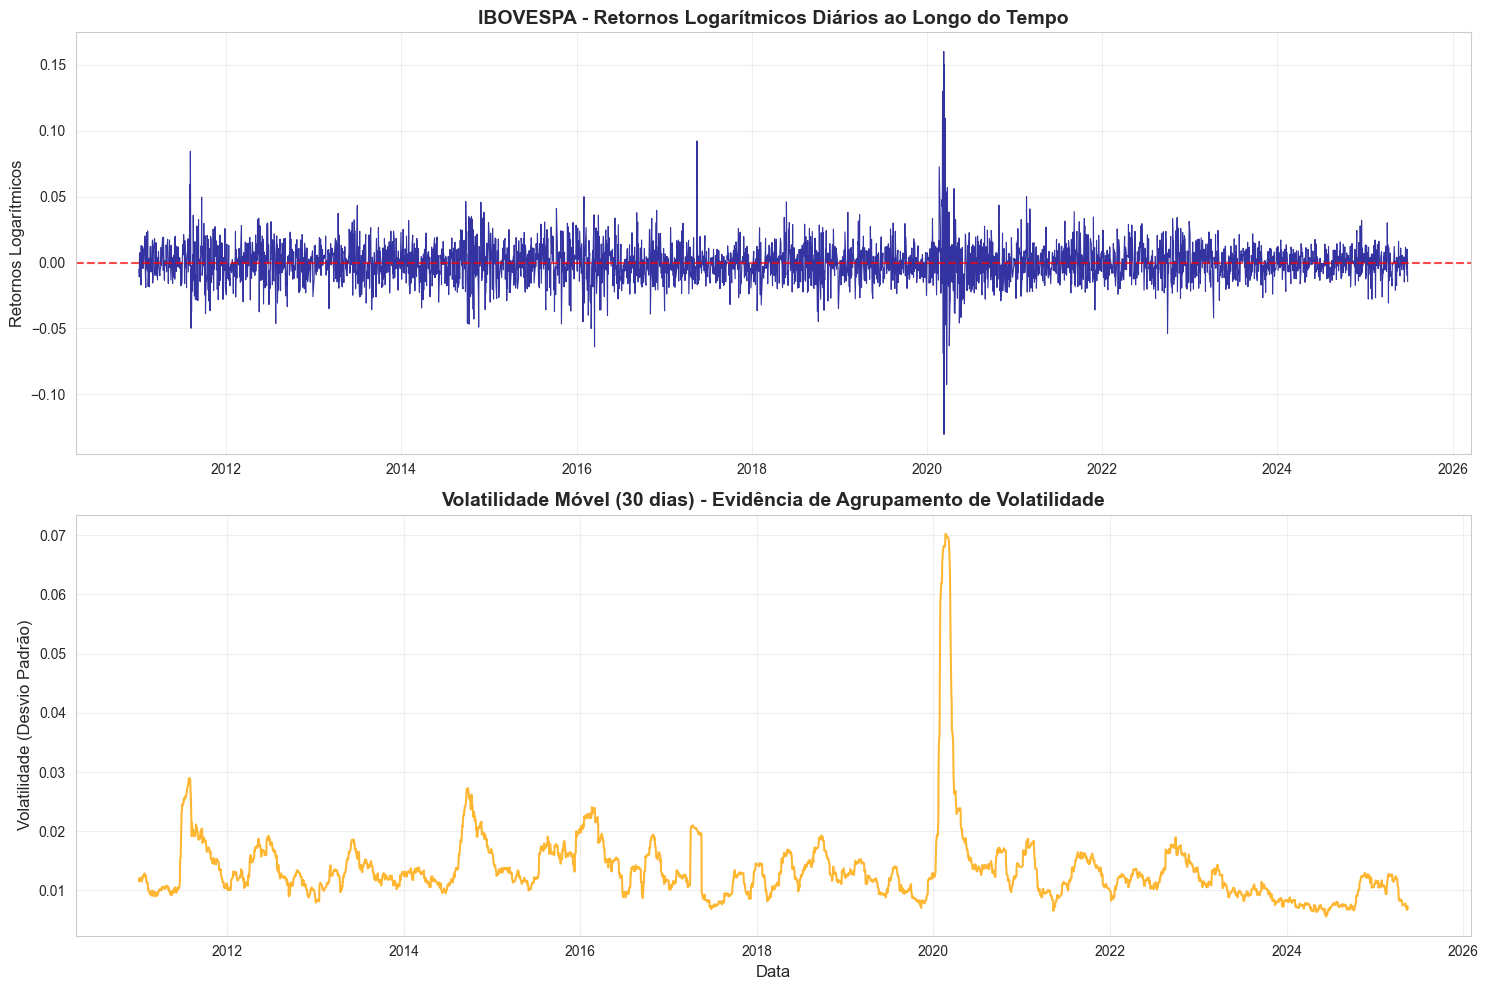

In [94]:
def executar_fase_1_completa(caminho_arquivo):
    """
    Executa toda a Fase 1 do EAP de forma sequencial
    """
    print("=" * 80)
    print("EXECUÇÃO COMPLETA DA FASE 1")
    print("=" * 80)

    try:
        # Executa todos os blocos sequencialmente
        dados = carregar_e_validar_dados(caminho_arquivo)
        dados_limpos = limpar_e_tratar_dados(dados)
        stats = gerar_estatisticas_descritivas(dados_limpos)
        plotar_preco_e_volume(dados_limpos)
        dados_com_retornos, retornos = calcular_retornos_logaritmicos(dados_limpos)
        analisar_distribuicao_retornos(retornos)
        analisar_volatility_clustering(retornos)


        return dados_com_retornos, {'stats': stats}

    except Exception as e:
        print(f"\nERRO NA EXECUÇÃO: {str(e)}")
        raise


dados, resultados = executar_fase_1_completa('dados_bovespa.csv')

Fase 1 Completa!

--------------------------------------------------------------------------------------------------------------
## Seção 2: Definição do Alvo e Engenharia de Atributos

A fase de engenharia de atributos é onde a "inteligência" do nosso modelo é realmente criada. A qualidade das variáveis que geramos aqui define o potencial máximo de acerto do projeto. Um erro simples nesta etapa, como usar dados do futuro para criar um indicador, pode criar um modelo que parece ótimo nos testes, mas que não funciona na vida real.


## Imports

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')

## Carregamento dos Dados

## Funções Auxiliares

Implementação manual dos indicadores técnicos:

In [96]:
def calcular_sma(serie, periodo):
    """
    Calcula a Média Móvel Simples (SMA)
    Compatível com NumPy 2.0+
    """
    return serie.rolling(window=periodo, min_periods=periodo).mean()

def calcular_retornos_log(serie):
    """
    Calcula retornos logarítmicos
    Compatível com NumPy 2.0+
    """
    return np.log(serie / serie.shift(1))

def criar_lags_retornos(retornos, max_lag=5):
    """
    Cria lags dos retornos
    Compatível com NumPy 2.0+
    """
    lags = {}
    for lag in range(1, max_lag + 1):
        lags[f'Return_Lag_{lag}'] = retornos.shift(lag)
    return lags

## Carregamento dos Dados

In [97]:
# Carrega os dados limpos da Fase 1

print(f'Dados carregados: {len(dados)} registros')
print(f'Período: {dados.index.min()} a {dados.index.max()}')
print(f'Colunas: {list(dados.columns)}')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DOS DADOS ===')
dados.head()

Dados carregados: 3592 registros
Período: 2011-01-03 00:00:00 a 2025-06-30 00:00:00
Colunas: ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Retornos_Log']

=== PRIMEIRAS LINHAS DOS DADOS ===


,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retornos_Log
Data,,,,,,,
2025-06-30,138.855,136.865,139.103,136.430,"7,68B","1,45%",NaN
2025-06-27,136.866,137.113,137.209,136.469,"6,24B","-0,18%",-0.014428
2025-06-26,137.114,135.767,137.353,135.756,"8,02B","0,99%",0.001810
2025-06-25,135.767,137.163,137.163,135.565,"7,71B","-1,02%",-0.009873
2025-06-24,137.165,136.552,138.156,136.254,"8,08B","0,45%",0.010244


## Criação da Variável Alvo (Target)

Criei a variável alvo:
- **Target = 1** se Close(t+1) > Close(t)
- **Target = 0** caso contrário

In [98]:
# Copia os dados para não modificar o original
dados_com_target = dados.copy()
col_close = 'Último'

# Cria a variável alvo
close_amanha = dados_com_target[col_close].shift(-1)
close_hoje = dados_com_target[col_close]
dados_com_target['Target'] = (close_amanha > close_hoje).astype(int)

# Remove a última linha que contém NaN no Target
dados_com_target = dados_com_target.dropna(subset=['Target'])

print('\n=== CRIAÇÃO DA VARIÁVEL ALVO ===')
print('Variável Target criada com sucesso')
print('Lógica: Target = 1 se Close(t+1) > Close(t), 0 caso contrário')
print(f'Registros após remoção de NaN: {len(dados_com_target)}')

# Visualiza os primeiros registros com o target
print('\n=== PRIMEIROS REGISTROS COM TARGET ===')
dados_com_target[['Abertura', 'Máxima', 'Mínima', 'Último', 'Target']].head(10)


=== CRIAÇÃO DA VARIÁVEL ALVO ===
Variável Target criada com sucesso
Lógica: Target = 1 se Close(t+1) > Close(t), 0 caso contrário
Registros após remoção de NaN: 3592

=== PRIMEIROS REGISTROS COM TARGET ===


,Abertura,Máxima,Mínima,Último,Target
Data,,,,,
2025-06-30,136.865,139.103,136.430,138.855,0
2025-06-27,137.113,137.209,136.469,136.866,1
2025-06-26,135.767,137.353,135.756,137.114,0
2025-06-25,137.163,137.163,135.565,135.767,1
2025-06-24,136.552,138.156,136.254,137.165,0
2025-06-23,137.116,137.130,135.835,136.551,1
2025-06-20,138.715,138.719,136.815,137.116,1
2025-06-18,138.844,139.161,138.443,138.717,1
2025-06-17,139.256,139.497,138.293,138.840,1


## Análise da Distribuição de Classes

=== ANÁLISE DA DISTRIBUIÇÃO DE CLASSES ===
✓ Distribuição absoluta:
   - Classe 0: 1836 (51.11%)
   - Classe 1: 1756 (48.89%)

✓ Análise de desbalanceamento:
   - Classe majoritária: 0 (51.11%)
   - Razão de desbalanceamento: 1.05:1
   - Status: BALANCEADO (razão <= 1.5)


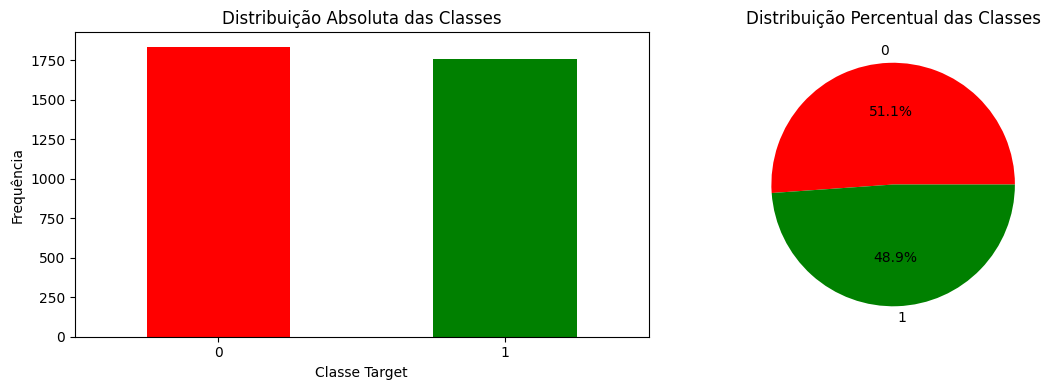

In [99]:
# Calcula e analisa a frequência das classes 0 e 1
distribuicao = dados_com_target['Target'].value_counts()
proporcoes = dados_com_target['Target'].value_counts(normalize=True)

# Análise de desbalanceamento
classe_majoritaria = proporcoes.idxmax()
prop_majoritaria = proporcoes.max()
prop_minoritaria = proporcoes.min()
razao_desbalanceamento = prop_majoritaria / prop_minoritaria

print('=== ANÁLISE DA DISTRIBUIÇÃO DE CLASSES ===')
print('✓ Distribuição absoluta:')
for classe, count in distribuicao.items():
    print(f'   - Classe {classe}: {count} ({proporcoes[classe]:.2%})')

print('\n✓ Análise de desbalanceamento:')
print(f'   - Classe majoritária: {classe_majoritaria} ({prop_majoritaria:.2%})')
print(f'   - Razão de desbalanceamento: {razao_desbalanceamento:.2f}:1')

if razao_desbalanceamento > 1.5:
    print('   - Status: DESBALANCEADO (razão > 1.5)')
    print('   - Implicações:')
    print('     • Acurácia não é uma métrica confiável')
    print('     • Usar Precisão, Recall e F1-Score')
    print('     • Considerar scale_pos_weight no XGBoost')
else:
    print('   - Status: BALANCEADO (razão <= 1.5)')

# Visualização gráfica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gráfico de barras
distribuicao.plot(kind='bar', ax=ax1, color=['red', 'green'])
ax1.set_title('Distribuição Absoluta das Classes')
ax1.set_xlabel('Classe Target')
ax1.set_ylabel('Frequência')
ax1.tick_params(axis='x', rotation=0)

# Gráfico de pizza
proporcoes.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['red', 'green'])
ax2.set_title('Distribuição Percentual das Classes')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## Engenharia de Atributos

### Atributos de Momento (Lags de Retornos)

In [100]:
# Copia os dados com target para adicionar features
dados_com_features = dados_com_target.copy()

# Calcula retornos logarítmicos usando função manual
dados_com_features['Retornos_Log'] = calcular_retornos_log(dados_com_features[col_close])

# Dicionário para armazenar informações dos atributos criados
dicionario_atributos = {}

# Cria lags dos retornos (1 a 5 dias)
print('=== CRIANDO ATRIBUTOS DE MOMENTO ===')
print('Usando implementação manual')

lags_retornos = criar_lags_retornos(dados_com_features['Retornos_Log'], 5)
for col_name, serie_lag in lags_retornos.items():
    dados_com_features[col_name] = serie_lag
    lag_num = col_name.split('_')[-1]
    
    # Adiciona ao dicionário de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'log(Close(t-{lag_num}) / Close(t-{lag_num}-1))',
        'dados_entrada': 'Close',
        'intuicao_financeira': f'Captura o momentum de {lag_num} dia(s) atrás',
        'categoria': 'Momento'
    }
    print(f'Criado: {col_name}')

print('\nAtributos de momento criados com sucesso!')
print('Capturam informações de momentum de curto prazo')

# Visualiza os novos atributos
colunas_momento = [f'Return_Lag_{i}' for i in range(1, 6)]
print('\n=== PRIMEIROS REGISTROS COM ATRIBUTOS DE MOMENTO ===')
dados_com_features[['Último', 'Retornos_Log'] + colunas_momento + ['Target']].head(10)

=== CRIANDO ATRIBUTOS DE MOMENTO ===
Usando implementação manual
Criado: Return_Lag_1
Criado: Return_Lag_2
Criado: Return_Lag_3
Criado: Return_Lag_4
Criado: Return_Lag_5

Atributos de momento criados com sucesso!
Capturam informações de momentum de curto prazo

=== PRIMEIROS REGISTROS COM ATRIBUTOS DE MOMENTO ===


,Último,Retornos_Log,Return_Lag_1,Return_Lag_2,Return_Lag_3,Return_Lag_4,Return_Lag_5,Target
Data,,,,,,,,
2025-06-30,138.855,NaN,NaN,NaN,NaN,NaN,NaN,0
2025-06-27,136.866,-0.014428,NaN,NaN,NaN,NaN,NaN,1
2025-06-26,137.114,0.001810,-0.014428,NaN,NaN,NaN,NaN,0
2025-06-25,135.767,-0.009873,0.001810,-0.014428,NaN,NaN,NaN,1
2025-06-24,137.165,0.010244,-0.009873,0.001810,-0.014428,NaN,NaN,0
2025-06-23,136.551,-0.004486,0.010244,-0.009873,0.001810,-0.014428,NaN,1
2025-06-20,137.116,0.004129,-0.004486,0.010244,-0.009873,0.001810,-0.014428,1
2025-06-18,138.717,0.011609,0.004129,-0.004486,0.010244,-0.009873,0.001810,1
2025-06-17,138.840,0.000886,0.011609,0.004129,-0.004486,0.010244,-0.009873,1


### Atributos de Tendência (SMAs e Ratios)

In [101]:
# Cria médias móveis simples usando função manual
periodos_sma = [5, 10, 20]


for periodo in periodos_sma:
    col_name = f'SMA_{periodo}'
    dados_com_features[col_name] = calcular_sma(dados_com_features[col_close], periodo)
    
    # Adiciona ao dicionário de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'Média móvel simples de {periodo} períodos',
        'dados_entrada': 'Close',
        'intuicao_financeira': f'Tendência de {"curto" if periodo <= 10 else "médio"} prazo',
        'categoria': 'Tendência'
    }

# Cria ratios entre preço e SMAs

for periodo in periodos_sma:
    col_name = f'Close_SMA_{periodo}_Ratio'
    dados_com_features[col_name] = dados_com_features[col_close] / dados_com_features[f'SMA_{periodo}']
    
    # Adiciona ao dicionário de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'Close / SMA_{periodo}',
        'dados_entrada': 'Close, SMA',
        'intuicao_financeira': f'Posição relativa do preço vs tendência de {periodo} dias',
        'categoria': 'Tendência'
    }

# Cria ratios entre SMAs
dados_com_features['SMA_5_10_Ratio'] = dados_com_features['SMA_5'] / dados_com_features['SMA_10']
dados_com_features['SMA_10_20_Ratio'] = dados_com_features['SMA_10'] / dados_com_features['SMA_20']

# Adiciona ao dicionário
dicionario_atributos['SMA_5_10_Ratio'] = {
    'calculo': 'SMA_5 / SMA_10',
    'dados_entrada': 'SMA_5, SMA_10',
    'intuicao_financeira': 'Divergência entre tendências de curto e médio prazo',
    'categoria': 'Tendência'
}

dicionario_atributos['SMA_10_20_Ratio'] = {
    'calculo': 'SMA_10 / SMA_20',
    'dados_entrada': 'SMA_10, SMA_20',
    'intuicao_financeira': 'Divergência entre tendências de médio prazo',
    'categoria': 'Tendência'
}

## Finalização e Limpeza dos Dados

In [102]:
# Remove registros com NaN (causados pelos lags e médias móveis)
dados_finais = dados_com_features.dropna()

print('=== FINALIZAÇÃO DOS DADOS ===')
print(f'Registros antes da limpeza: {len(dados_com_features)}')
print(f'Registros após limpeza: {len(dados_finais)}')
print(f'Registros removidos: {len(dados_com_features) - len(dados_finais)}')
print(f'Total de colunas: {len(dados_finais.columns)}')

# Lista todas as colunas criadas
colunas_originais = dados.columns.tolist()
colunas_criadas = [col for col in dados_finais.columns if col not in colunas_originais]

print(f'\nColunas criadas ({len(colunas_criadas)}): {colunas_criadas}')

# Verifica distribuição final do target
distribuicao_final = dados_finais['Target'].value_counts(normalize=True)
print(f'\nDistribuição final do Target:')
for classe, prop in distribuicao_final.items():
    print(f'   - Classe {classe}: {prop:.2%}')

# Salva os dados processados
dados_finais.to_csv('dados_fase2_completos.csv')
print(f'\nDados salvos em: dados_fase2_completos.csv')

# Salva o dicionário de atributos
with open('dicionario_atributos_fase2.json', 'w', encoding='utf-8') as f:
    json.dump(dicionario_atributos, f, indent=2, ensure_ascii=False)
print(f'Dicionário salvo em: dicionario_atributos_fase2.json')

# Visualiza o dataset final
print('\n=== DATASET FINAL ===')
dados_finais.head()

=== FINALIZAÇÃO DOS DADOS ===
Registros antes da limpeza: 3592
Registros após limpeza: 3572
Registros removidos: 20
Total de colunas: 21

Colunas criadas (14): ['Target', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'SMA_5', 'SMA_10', 'SMA_20', 'Close_SMA_5_Ratio', 'Close_SMA_10_Ratio', 'Close_SMA_20_Ratio', 'SMA_5_10_Ratio', 'SMA_10_20_Ratio']

Distribuição final do Target:
   - Classe 0: 51.18%
   - Classe 1: 48.82%

Dados salvos em: dados_fase2_completos.csv
Dicionário salvo em: dicionario_atributos_fase2.json

=== DATASET FINAL ===


,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retornos_Log,Target,Return_Lag_1,Return_Lag_2,...,Return_Lag_4,Return_Lag_5,SMA_5,SMA_10,SMA_20,Close_SMA_5_Ratio,Close_SMA_10_Ratio,Close_SMA_20_Ratio,SMA_5_10_Ratio,SMA_10_20_Ratio
Data,,,,,,,,,,,,,,,,,,,,,
2025-06-02,136.787,137.026,138.471,136.483,"9,10B","-0,18%",-0.005533,1,0.003963,0.005607,...,0.002965,-0.005416,136.7346,136.7949,137.2098,1.000383,0.999942,0.996919,0.999559,0.996976
2025-05-30,137.027,138.546,138.637,136.726,"15,14B","-1,09%",0.001753,1,-0.005533,0.003963,...,0.000984,0.002965,136.9196,136.7763,137.1184,1.000784,1.001833,0.999333,1.001048,0.997505
2025-05-29,138.534,138.869,139.108,137.993,"8,83B","-0,25%",0.010938,1,0.001753,-0.005533,...,0.005607,0.000984,137.3792,136.8497,137.2018,1.008406,1.012308,1.009710,1.003869,0.997434
2025-05-28,138.888,139.541,139.547,138.580,"9,73B","-0,47%",0.002552,1,0.010938,0.001753,...,0.003963,0.005607,137.7564,137.0257,137.2905,1.008215,1.013591,1.011636,1.005333,0.998071
2025-05-27,139.541,138.136,140.382,138.136,"11,19B","1,02%",0.004691,0,0.002552,0.010938,...,-0.005533,0.003963,138.1554,137.3362,137.4792,1.010029,1.016054,1.014997,1.005965,0.998960


Fase 2 Completa!

--------------------------------------------------------------------------------------------------------------
## Seção 3: Preparação da Base para Modelagem

A Fase 3 é a arrumação final dos dados antes de entregá-los para o modelo. A tarefa mais crítica aqui é dividir o dataset em treino e teste. A regra de ouro é nunca misturar o tempo: usamos o passado para treinar e separamos o futuro para testar. Se errarmos nessa divisão, o modelo pode "colar" as respostas do futuro, nos dando uma falsa impressão de acerto, quando na prática ele não saberia prever nada.


## Imports

In [103]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')

## Carregamento dos Dados da Fase 2

In [104]:
# Carrega os dados processados da Fase 2
dados_com_features = pd.read_csv('dados_fase2_completos.csv', index_col=0, parse_dates=True)

print(f'\n=== INFORMAÇÕES DOS DADOS ===')
print(f'Registros: {len(dados_com_features)}')
print(f'Período: {dados_com_features.index.min()} a {dados_com_features.index.max()}')
print(f'Colunas: {len(dados_com_features.columns)}')
print(f'Colunas disponíveis: {list(dados_com_features.columns)}')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DOS DADOS ===')
dados_com_features.head()


=== INFORMAÇÕES DOS DADOS ===
Registros: 3572
Período: 2011-01-03 00:00:00 a 2025-06-02 00:00:00
Colunas: 21
Colunas disponíveis: ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Retornos_Log', 'Target', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'SMA_5', 'SMA_10', 'SMA_20', 'Close_SMA_5_Ratio', 'Close_SMA_10_Ratio', 'Close_SMA_20_Ratio', 'SMA_5_10_Ratio', 'SMA_10_20_Ratio']

=== PRIMEIRAS LINHAS DOS DADOS ===


,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retornos_Log,Target,Return_Lag_1,Return_Lag_2,...,Return_Lag_4,Return_Lag_5,SMA_5,SMA_10,SMA_20,Close_SMA_5_Ratio,Close_SMA_10_Ratio,Close_SMA_20_Ratio,SMA_5_10_Ratio,SMA_10_20_Ratio
Data,,,,,,,,,,,,,,,,,,,,,
2025-06-02,136.787,137.026,138.471,136.483,"9,10B","-0,18%",-0.005533,1,0.003963,0.005607,...,0.002965,-0.005416,136.7346,136.7949,137.2098,1.000383,0.999942,0.996919,0.999559,0.996976
2025-05-30,137.027,138.546,138.637,136.726,"15,14B","-1,09%",0.001753,1,-0.005533,0.003963,...,0.000984,0.002965,136.9196,136.7763,137.1184,1.000784,1.001833,0.999333,1.001048,0.997505
2025-05-29,138.534,138.869,139.108,137.993,"8,83B","-0,25%",0.010938,1,0.001753,-0.005533,...,0.005607,0.000984,137.3792,136.8497,137.2018,1.008406,1.012308,1.009710,1.003869,0.997434
2025-05-28,138.888,139.541,139.547,138.580,"9,73B","-0,47%",0.002552,1,0.010938,0.001753,...,0.003963,0.005607,137.7564,137.0257,137.2905,1.008215,1.013591,1.011636,1.005333,0.998071
2025-05-27,139.541,138.136,140.382,138.136,"11,19B","1,02%",0.004691,0,0.002552,0.010938,...,-0.005533,0.003963,138.1554,137.3362,137.4792,1.010029,1.016054,1.014997,1.005965,0.998960


## Estruturação com Janela Deslizante

### Definição da Janela de Entrada (Lookback Window)

Transformei a série temporal em um dataset tabular onde cada linha contém os atributos dos últimos **n=5 dias** e o alvo correspondente.

In [105]:
# Configurações da janela deslizante
JANELA_TAMANHO = 5  # Lookback window de 5 dias

print(f'=== ESTRUTURAÇÃO COM JANELA DESLIZANTE ===')
print(f'Tamanho da janela: {JANELA_TAMANHO} dias')

# Converter colunas críticas para numérico ANTES da seleção
print('\n=== CONVERTENDO COLUNAS CRÍTICAS ===')

# Converter Volume se ainda estiver como string
if 'Vol.' in dados_com_features.columns and dados_com_features['Vol.'].dtype == 'object':
    def converter_volume_seguro(vol_str):
        try:
            if pd.isna(vol_str) or vol_str == '-': return np.nan
            vol_str = str(vol_str).replace(',', '.')
            if 'B' in vol_str: return float(vol_str.replace('B', '')) * 1e9
            elif 'M' in vol_str: return float(vol_str.replace('M', '')) * 1e6
            elif 'K' in vol_str: return float(vol_str.replace('K', '')) * 1e3
            return float(vol_str)
        except: return np.nan
    
    dados_com_features['Vol.'] = dados_com_features['Vol.'].apply(converter_volume_seguro)
    print("✓ Volume convertido para numérico")

# Converter Variação se ainda estiver como string  
if 'Var%' in dados_com_features.columns and dados_com_features['Var%'].dtype == 'object':
    def converter_variacao(var_str):
        try:
            if pd.isna(var_str): return np.nan
            var_str = str(var_str).replace('%', '').replace(',', '.')
            return float(var_str)
        except: return np.nan
    
    dados_com_features['Var%'] = dados_com_features['Var%'].apply(converter_variacao)
    print("✓ Variação convertida para numérico")

# Identifica features numéricas (exclui Target)
colunas_excluir = ['Target']
features_numericas = dados_com_features.select_dtypes(include=[np.number]).columns
features_numericas = [col for col in features_numericas if col not in colunas_excluir]

print(f'\nFeatures selecionadas: {len(features_numericas)}')
print(f'Features: {features_numericas[:10]}...')  # Mostra apenas as primeiras 10

# Remove linhas com NaN nas features
dados_limpos = dados_com_features[features_numericas + ['Target']].dropna()
print(f'Dados limpos: {len(dados_limpos)} registros')

=== ESTRUTURAÇÃO COM JANELA DESLIZANTE ===
Tamanho da janela: 5 dias

=== CONVERTENDO COLUNAS CRÍTICAS ===
✓ Volume convertido para numérico
✓ Variação convertida para numérico

Features selecionadas: 20
Features: ['Último', 'Abertura', 'Máxima', 'Mínima', 'Vol.', 'Var%', 'Retornos_Log', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3']...
Dados limpos: 3572 registros


### Implementação da Lógica de Janela Deslizante

In [106]:
# Cria estrutura de janela deslizante
print('=== CRIANDO ESTRUTURA DE JANELA DESLIZANTE ===')

X_list = []
y_list = []
indices_list = []


# Itera pelos dados criando janelas deslizantes
for i in range(JANELA_TAMANHO, len(dados_limpos)):
    # Janela de features (últimos n dias)
    janela_features = dados_limpos[features_numericas].iloc[i-JANELA_TAMANHO:i].values
    
    # Achata a janela (transforma matriz em vetor)
    janela_achatada = janela_features.flatten()
    
    # Target correspondente
    target = dados_limpos['Target'].iloc[i]
    
    X_list.append(janela_achatada)
    y_list.append(target)
    indices_list.append(dados_limpos.index[i])


# Converte para arrays numpy
X = np.array(X_list)
y = np.array(y_list)

print(f'Janelas criadas: {len(X_list)}')
print(f'Shape do X: {X.shape}')
print(f'Shape do y: {y.shape}')

# Cria nomes das colunas para o DataFrame final
nomes_colunas = []
for lag in range(JANELA_TAMANHO, 0, -1):
    for feature in features_numericas:
        nomes_colunas.append(f"{feature}_lag_{lag}")

print(f'Colunas criadas: {len(nomes_colunas)}')
print(f'Exemplo de colunas: {nomes_colunas[:5]}...')

# Cria DataFrame estruturado
dados_janela_deslizante = pd.DataFrame(
    X, 
    columns=nomes_colunas,
    index=indices_list
)
dados_janela_deslizante['Target'] = y

print(f'\nDataset estruturado criado: {X.shape[0]} amostras, {X.shape[1]} features')
print(f'Cada amostra contém {JANELA_TAMANHO} dias de {len(features_numericas)} features')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DO DATASET ESTRUTURADO ===')
dados_janela_deslizante.head()

=== CRIANDO ESTRUTURA DE JANELA DESLIZANTE ===
Janelas criadas: 3567
Shape do X: (3567, 100)
Shape do y: (3567,)
Colunas criadas: 100
Exemplo de colunas: ['Último_lag_5', 'Abertura_lag_5', 'Máxima_lag_5', 'Mínima_lag_5', 'Vol._lag_5']...

Dataset estruturado criado: 3567 amostras, 100 features
Cada amostra contém 5 dias de 20 features

=== PRIMEIRAS LINHAS DO DATASET ESTRUTURADO ===


,Último_lag_5,Abertura_lag_5,Máxima_lag_5,Mínima_lag_5,Vol._lag_5,Var%_lag_5,Retornos_Log_lag_5,Return_Lag_1_lag_5,Return_Lag_2_lag_5,Return_Lag_3_lag_5,...,Return_Lag_5_lag_1,SMA_5_lag_1,SMA_10_lag_1,SMA_20_lag_1,Close_SMA_5_Ratio_lag_1,Close_SMA_10_Ratio_lag_1,Close_SMA_20_Ratio_lag_1,SMA_5_10_Ratio_lag_1,SMA_10_20_Ratio_lag_1,Target
2025-05-26,136.787,137.026,138.471,136.483,9.100000e+09,-0.18,-0.005533,0.003963,0.005607,0.000984,...,0.003963,138.1554,137.3362,137.47920,1.010029,1.016054,1.014997,1.005965,0.998960,0
2025-05-23,137.027,138.546,138.637,136.726,1.514000e+10,-1.09,0.001753,-0.005533,0.003963,0.005607,...,-0.005533,138.4252,137.5799,137.52775,0.997911,1.004042,1.004423,1.006144,1.000379,0
2025-05-22,138.534,138.869,139.108,137.993,8.830000e+09,-0.25,0.010938,0.001753,-0.005533,0.003963,...,0.001753,138.5846,137.7521,137.59140,0.994512,1.000522,1.001691,1.006043,1.001168,1
2025-05-21,138.888,139.541,139.547,138.580,9.730000e+09,-0.47,0.002552,0.010938,0.001753,-0.005533,...,0.010938,138.3324,137.8558,137.59925,0.992342,0.995772,0.997629,1.003457,1.001864,1
2025-05-20,139.541,138.136,140.382,138.136,1.119000e+10,1.02,0.004691,0.002552,0.010938,0.001753,...,0.002552,138.1310,137.9437,137.55745,0.998190,0.999545,1.002352,1.001358,1.002808,0


## Divisão Cronológica dos Dados

### Definição da Data de Corte

Separamos os dados em treino, validação e teste **sem usar amostragem aleatória**, respeitando a ordem cronológica.

In [ ]:
# PRIMEIRO: Ordenar os dados em ordem cronológica crescente
dados_janela_deslizante = dados_janela_deslizante.sort_index()

# Configurações da divisão
DIAS_TESTE = 30  # Últimos 30 dias úteis para teste
PROPORCAO_VALIDACAO = 0.2  # 20% do restante para validação

print(f'\n=== DIVISÃO CRONOLÓGICA DOS DADOS ===')
print(f'Estratégia: Últimos {DIAS_TESTE} dias para teste, restante dividido treino/validação')

# Calcula pontos de corte
total_amostras = len(dados_janela_deslizante)

# TESTE: Últimos 30 registros (mais recentes) - FINAL DO DATASET
dados_teste = dados_janela_deslizante.tail(DIAS_TESTE)

# VALIDAÇÃO: 20% dos dados restantes (antes do teste)
dados_restantes = dados_janela_deslizante.head(total_amostras - DIAS_TESTE)
tamanho_validacao = int(len(dados_restantes) * PROPORCAO_VALIDACAO)
dados_validacao = dados_restantes.tail(tamanho_validacao)

# TREINO: O que sobrou (mais antigos)
dados_treino = dados_restantes.head(len(dados_restantes) - tamanho_validacao)

print(f'Total de amostras: {total_amostras}')
print(f'Treino: {len(dados_treino)} dias (mais antigos)')
print(f'Validação: {len(dados_validacao)} dias (intermediários)')
print(f'Teste: {len(dados_teste)} dias (mais recentes)')

print(f'\n=== PERÍODOS FINAIS ===')
print(f'Treino: {dados_treino.index.min()} até {dados_treino.index.max()} ({len(dados_treino)} amostras)')
print(f'Validação: {dados_validacao.index.min()} até {dados_validacao.index.max()} ({len(dados_validacao)} amostras)')
print(f'Teste: {dados_teste.index.min()} até {dados_teste.index.max()} ({len(dados_teste)} amostras)')

Após ordenação:
Primeira data: 2011-01-03 00:00:00
Última data: 2025-05-26 00:00:00
Dados estão em ordem crescente? True

=== DIVISÃO CRONOLÓGICA DOS DADOS ===
Estratégia: Últimos 30 dias para teste, restante dividido treino/validação
Total de amostras: 3567
Treino: 2830 dias (mais antigos)
Validação: 707 dias (intermediários)
Teste: 30 dias (mais recentes)

=== PERÍODOS FINAIS ===
Treino: 2011-01-03 00:00:00 até 2022-06-09 00:00:00 (2830 amostras)
Validação: 2022-06-10 00:00:00 até 2025-04-09 00:00:00 (707 amostras)
Teste: 2025-04-10 00:00:00 até 2025-05-26 00:00:00 (30 amostras)


### Separação de Features e Target

=== SEPARAÇÃO DE FEATURES E TARGET ===
Features: 100
X_train shape: (2830, 100)
y_train shape: (2830,)
X_val shape: (707, 100)
y_val shape: (707,)
X_test shape: (30, 100)
y_test shape: (30,)

Distribuição de classes no treino:
   - Classe 0: 51.17%
   - Classe 1: 48.83%
Distribuição de classes na validação:
   - Classe 0: 50.78%
   - Classe 1: 49.22%
Distribuição de classes no teste:
   - Classe 0: 66.67%
   - Classe 1: 33.33%


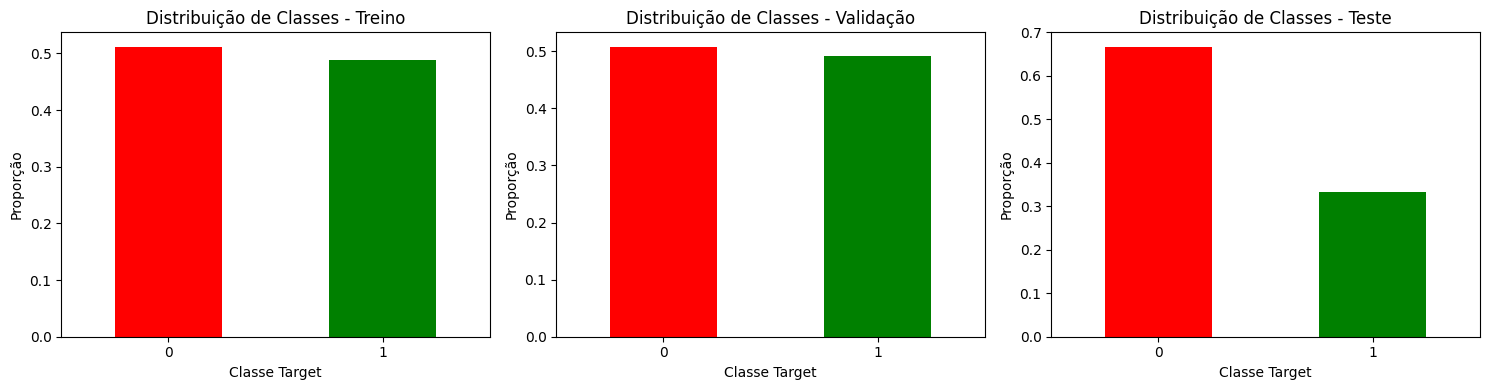

In [108]:
# Separa features e target
colunas_features = [col for col in dados_janela_deslizante.columns if col != 'Target']

X_train = dados_treino[colunas_features]
y_train = dados_treino['Target']
X_val = dados_validacao[colunas_features]
y_val = dados_validacao['Target']
X_test = dados_teste[colunas_features]
y_test = dados_teste['Target']

print(f'=== SEPARAÇÃO DE FEATURES E TARGET ===')
print(f'Features: {len(colunas_features)}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Verifica distribuição de classes
dist_treino = y_train.value_counts(normalize=True)
dist_validacao = y_val.value_counts(normalize=True)
dist_teste = y_test.value_counts(normalize=True)

print(f'\nDistribuição de classes no treino:')
for classe, prop in dist_treino.items():
    print(f'   - Classe {classe}: {prop:.2%}')

print(f'Distribuição de classes na validação:')
for classe, prop in dist_validacao.items():
    print(f'   - Classe {classe}: {prop:.2%}')

print(f'Distribuição de classes no teste:')
for classe, prop in dist_teste.items():
    print(f'   - Classe {classe}: {prop:.2%}')

# Visualização gráfica da distribuição
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Distribuição no treino
dist_treino.plot(kind='bar', ax=ax1, color=['red', 'green'])
ax1.set_title('Distribuição de Classes - Treino')
ax1.set_xlabel('Classe Target')
ax1.set_ylabel('Proporção')
ax1.tick_params(axis='x', rotation=0)

# Distribuição na validação
dist_validacao.plot(kind='bar', ax=ax2, color=['red', 'green'])
ax2.set_title('Distribuição de Classes - Validação')
ax2.set_xlabel('Classe Target')
ax2.set_ylabel('Proporção')
ax2.tick_params(axis='x', rotation=0)

# Distribuição no teste
dist_teste.plot(kind='bar', ax=ax3, color=['red', 'green'])
ax3.set_title('Distribuição de Classes - Teste')
ax3.set_xlabel('Classe Target')
ax3.set_ylabel('Proporção')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Escalonamento de Atributos

### Instanciação e Ajuste do StandardScaler

**Importante**: O scaler é ajustado **APENAS** no conjunto de treino para evitar data leakage.

In [109]:
print(f'=== ESCALONAMENTO DE ATRIBUTOS ===')

# 3.3.1 - Instancia StandardScaler
scaler = StandardScaler()
print('StandardScaler instanciado')

# 3.3.2 - Ajusta APENAS no conjunto de treino
scaler.fit(X_train)
print('Scaler ajustado APENAS nos dados de treino')
print('Isso previne data leakage!')

# Mostra estatísticas do scaler
print(f'\nEstatísticas do scaler (baseadas no treino):')
print(f'   - Número de features: {len(scaler.mean_)}')
print(f'   - Média das primeiras 5 features: {scaler.mean_[:5]}')
print(f'   - Desvio padrão das primeiras 5 features: {scaler.scale_[:5]}')

# 3.3.3 - Aplica transformação em todos os conjuntos
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'\n=== APLICAÇÃO DA TRANSFORMAÇÃO ===')
print('Transformação aplicada em treino, validação e teste')
print('Usando os mesmos parâmetros ajustados no treino')

# Converte de volta para DataFrame mantendo índices e nomes das colunas
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,
    columns=X_train.columns
)

X_val_scaled = pd.DataFrame(
    X_val_scaled,
    index=X_val.index,
    columns=X_val.columns
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,
    columns=X_test.columns
)

print(f'\nDataFrames escalonados criados:')
print(f'   - X_train_scaled shape: {X_train_scaled.shape}')
print(f'   - X_val_scaled shape: {X_val_scaled.shape}')
print(f'   - X_test_scaled shape: {X_test_scaled.shape}')

# Verifica se a transformação foi aplicada corretamente
print(f'\nVerificação da transformação:')
print(f'   - Média do treino escalonado: {X_train_scaled.mean().mean():.6f} (deve ser ~0)')
print(f'   - Desvio padrão do treino escalonado: {X_train_scaled.std().mean():.6f} (deve ser ~1)')

=== ESCALONAMENTO DE ATRIBUTOS ===
StandardScaler instanciado
Scaler ajustado APENAS nos dados de treino
Isso previne data leakage!

Estatísticas do scaler (baseadas no treino):
   - Número de features: 100
   - Média das primeiras 5 features: [7.39630827e+01 7.39534488e+01 7.46684438e+01 7.32390650e+01
 5.14028871e+06]
   - Desvio padrão das primeiras 5 features: [2.40527951e+01 2.40477461e+01 2.42200739e+01 2.38612935e+01
 3.18319348e+06]

=== APLICAÇÃO DA TRANSFORMAÇÃO ===
Transformação aplicada em treino, validação e teste
Usando os mesmos parâmetros ajustados no treino

DataFrames escalonados criados:
   - X_train_scaled shape: (2830, 100)
   - X_val_scaled shape: (707, 100)
   - X_test_scaled shape: (30, 100)

Verificação da transformação:
   - Média do treino escalonado: -0.000000 (deve ser ~0)
   - Desvio padrão do treino escalonado: 1.000177 (deve ser ~1)


### Aplicação da Transformação

In [110]:
# Aplica transformação em todos os conjuntos
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'=== APLICAÇÃO DA TRANSFORMAÇÃO ===')
print('Transformação aplicada em treino, validação e teste')
print('Usando os mesmos parâmetros ajustados no treino')

# Converte de volta para DataFrame mantendo índices e nomes das colunas
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,
    columns=X_train.columns
)

X_val_scaled = pd.DataFrame(
    X_val_scaled,
    index=X_val.index,
    columns=X_val.columns
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,
    columns=X_test.columns
)

print(f'\nDataFrames escalonados criados:')
print(f'   - X_train_scaled shape: {X_train_scaled.shape}')
print(f'   - X_val_scaled shape: {X_val_scaled.shape}')
print(f'   - X_test_scaled shape: {X_test_scaled.shape}')

# Verifica se a transformação foi aplicada corretamente
media_treino = X_train_scaled.mean().mean()
std_treino = X_train_scaled.std().mean()

print(f'\nVerificação da transformação:')
print(f'   - Média do treino escalonado: {media_treino:.6f} (deve ser ~0)')
print(f'   - Desvio padrão do treino escalonado: {std_treino:.6f} (deve ser ~1)')

if abs(media_treino) < 1e-10 and abs(std_treino - 1) < 0.1:
    print('Escalonamento aplicado corretamente!')
else:
    print('Verificar escalonamento - valores fora do esperado')

=== APLICAÇÃO DA TRANSFORMAÇÃO ===
Transformação aplicada em treino, validação e teste
Usando os mesmos parâmetros ajustados no treino

DataFrames escalonados criados:
   - X_train_scaled shape: (2830, 100)
   - X_val_scaled shape: (707, 100)
   - X_test_scaled shape: (30, 100)

Verificação da transformação:
   - Média do treino escalonado: -0.000000 (deve ser ~0)
   - Desvio padrão do treino escalonado: 1.000177 (deve ser ~1)
Escalonamento aplicado corretamente!


## Visualização dos Dados Preparados

=== VISUALIZAÇÃO DOS DADOS PREPARADOS ===


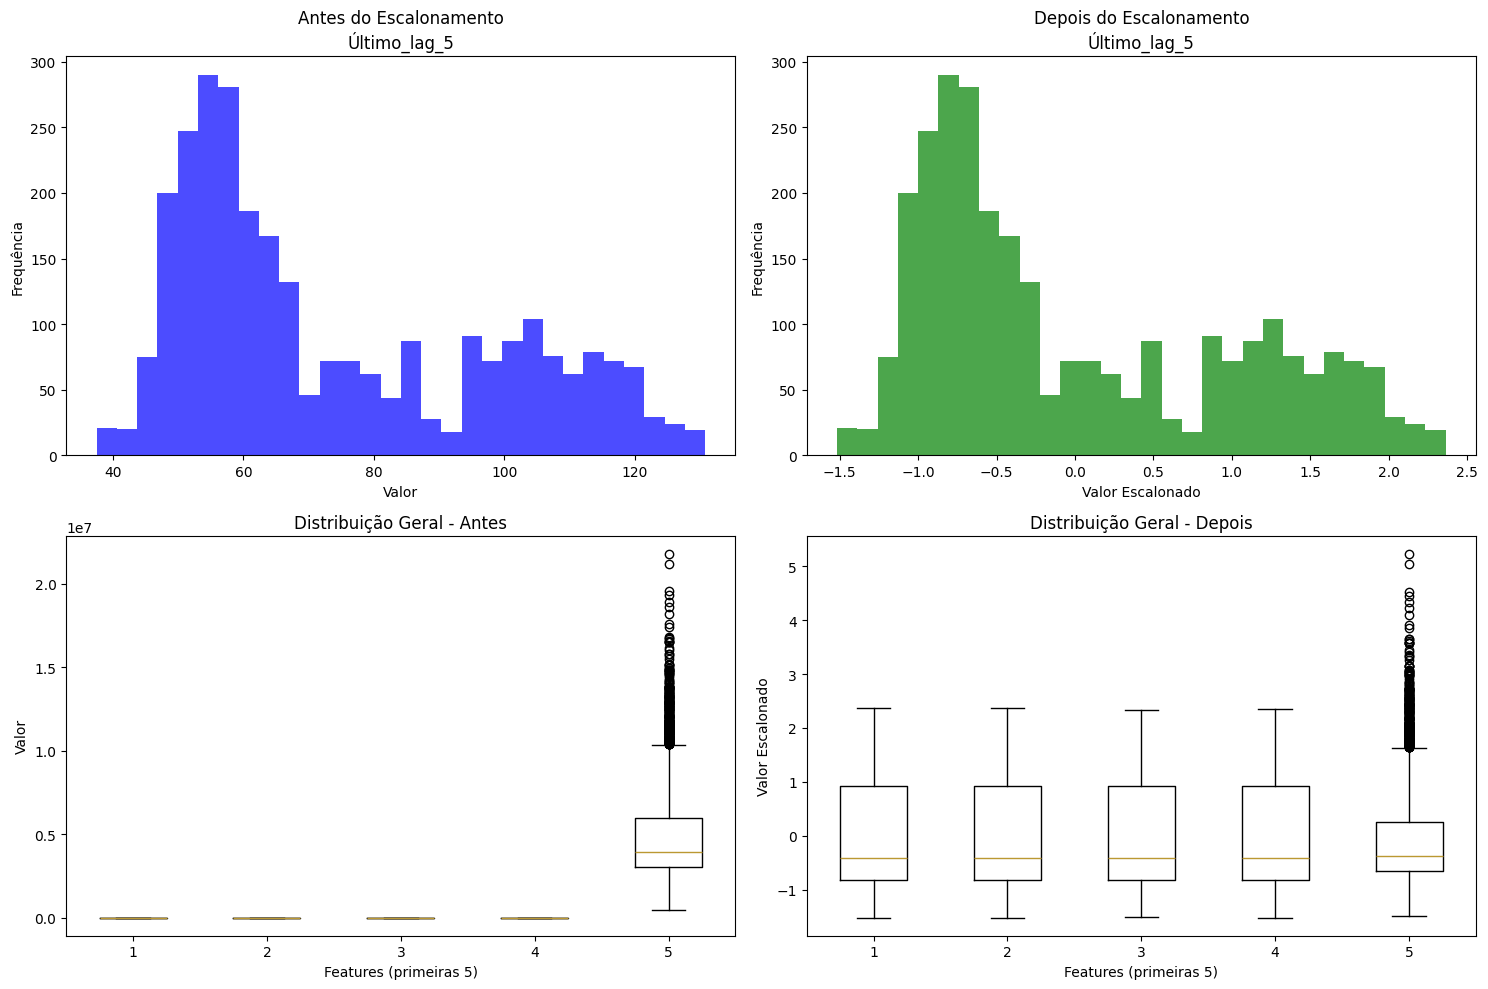


=== ESTATÍSTICAS DESCRITIVAS ===

Dados ANTES do escalonamento (primeiras 5 features):
       Último_lag_5  Abertura_lag_5  Máxima_lag_5  Mínima_lag_5    Vol._lag_5
count   2830.000000     2830.000000   2830.000000   2830.000000  2.830000e+03
mean      73.963083       73.953449     74.668444     73.239065  5.140289e+06
std       24.057046       24.051996     24.224354     23.865510  3.183756e+06
min       37.497000       37.501000     38.031000     37.046000  4.243200e+05
25%       54.337000       54.331750     54.866500     53.778250  3.050000e+06
50%       64.214000       64.206000     64.741000     63.625000  3.930000e+06
75%       96.118000       96.092500     97.083250     95.359000  5.970000e+06
max      130.776000      130.776000    131.190000    129.526000  2.177000e+07

Dados DEPOIS do escalonamento (primeiras 5 features):
       Último_lag_5  Abertura_lag_5  Máxima_lag_5  Mínima_lag_5    Vol._lag_5
count  2.830000e+03    2.830000e+03  2.830000e+03  2.830000e+03  2.830000e+03

In [111]:
print(f'=== VISUALIZAÇÃO DOS DADOS PREPARADOS ===')

# Comparação antes e depois do escalonamento
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Primeira feature - antes do escalonamento
primeira_feature = X_train.columns[0]
axes[0, 0].hist(X_train[primeira_feature], bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title(f'Antes do Escalonamento\n{primeira_feature}')
axes[0, 0].set_xlabel('Valor')
axes[0, 0].set_ylabel('Frequência')

# Primeira feature - depois do escalonamento
axes[0, 1].hist(X_train_scaled[primeira_feature], bins=30, alpha=0.7, color='green')
axes[0, 1].set_title(f'Depois do Escalonamento\n{primeira_feature}')
axes[0, 1].set_xlabel('Valor Escalonado')
axes[0, 1].set_ylabel('Frequência')

# Distribuição geral - antes
sample_features = X_train.iloc[:, :5]  # Primeiras 5 features
axes[1, 0].boxplot([sample_features[col].dropna() for col in sample_features.columns])
axes[1, 0].set_title('Distribuição Geral - Antes')
axes[1, 0].set_xlabel('Features (primeiras 5)')
axes[1, 0].set_ylabel('Valor')

# Distribuição geral - depois
sample_features_scaled = X_train_scaled.iloc[:, :5]  # Primeiras 5 features
axes[1, 1].boxplot([sample_features_scaled[col].dropna() for col in sample_features_scaled.columns])
axes[1, 1].set_title('Distribuição Geral - Depois')
axes[1, 1].set_xlabel('Features (primeiras 5)')
axes[1, 1].set_ylabel('Valor Escalonado')

plt.tight_layout()
plt.show()

# Mostra estatísticas descritivas
print('\n=== ESTATÍSTICAS DESCRITIVAS ===')
print('\nDados ANTES do escalonamento (primeiras 5 features):')
print(X_train.iloc[:, :5].describe())

print('\nDados DEPOIS do escalonamento (primeiras 5 features):')
print(X_train_scaled.iloc[:, :5].describe())

## Salvamento dos Dados Preparados

In [ ]:
# Salva os dados preparados
X_train.to_csv('X_train_fase3.csv')
X_val.to_csv('X_val_fase3.csv')
X_test.to_csv('X_test_fase3.csv')
y_train.to_csv('y_train_fase3.csv')
y_val.to_csv('y_val_fase3.csv')
y_test.to_csv('y_test_fase3.csv')

# Salva os dados escalonados
X_train_scaled.to_csv('X_train_scaled_fase3.csv')
X_val_scaled.to_csv('X_val_scaled_fase3.csv')
X_test_scaled.to_csv('X_test_scaled_fase3.csv')

# Salva informações da preparação
info_preparacao = {
    'janela_tamanho': JANELA_TAMANHO,
    'dias_teste': DIAS_TESTE,
    'proporcao_validacao': PROPORCAO_VALIDACAO,
    'total_features': len(colunas_features),
    'amostras_treino': len(X_train),
    'amostras_validacao': len(X_val),
    'amostras_teste': len(X_test),
    'features_originais': len(features_numericas),
    'periodo_treino': f'{X_train.index.min()} até {X_train.index.max()}',
    'periodo_validacao': f'{X_val.index.min()} até {X_val.index.max()}',
    'periodo_teste': f'{X_test.index.min()} até {X_test.index.max()}'
}

with open('info_preparacao_fase3.json', 'w', encoding='utf-8') as f:
    json.dump(info_preparacao, f, indent=2, ensure_ascii=False, default=str)

# Fase 4: Modelagem e Validação

A Fase 4 é a etapa de execução e aferição de performance dos modelos. Neste ponto, os algoritmos são treinados com o conjunto de dados de treino para aprender as relações entre os atributos e o alvo. O objetivo principal é desenvolver um modelo que não apenas se ajuste bem aos dados vistos, mas que também generalize seu aprendizado para dados futuros. O risco central a ser mitigado é o sobreajuste (overfitting), onde o modelo memoriza o ruído em vez dos padrões, tornando-se ineficaz na prática. A validação rigorosa com o conjunto de teste é, portanto, o procedimento crítico que quantifica a real capacidade preditiva do modelo.

## Imports

In [113]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")

## Carregamento dos Dados Preparados

In [114]:
# Carrega dados escalonados
X_train_scaled = pd.read_csv('X_train_scaled_fase3.csv', index_col=0, parse_dates=True)
X_val_scaled = pd.read_csv('X_val_scaled_fase3.csv', index_col=0, parse_dates=True)
X_test_scaled = pd.read_csv('X_test_scaled_fase3.csv', index_col=0, parse_dates=True)
    
# Carrega targets
y_train = pd.read_csv('y_train_fase3.csv', index_col=0, parse_dates=True).squeeze()
y_val = pd.read_csv('y_val_fase3.csv', index_col=0, parse_dates=True).squeeze()
y_test = pd.read_csv('y_test_fase3.csv', index_col=0, parse_dates=True).squeeze()
    
# Carrega informações da preparação
with open('info_preparacao_fase3.json', 'r', encoding='utf-8') as f:
    info_preparacao = json.load(f)
    
# Estrutura os dados conforme esperado pela Fase 4
dados_preparados = {
    'X_train_scaled': X_train_scaled,
    'y_train': y_train,
    'X_val_scaled': X_val_scaled,
    'y_val': y_val,
    'X_test_scaled': X_test_scaled,
    'y_test': y_test,
    'info_preparacao': info_preparacao
}

print("Dados estruturados para modelagem")
print(f"Amostras de treino: {len(X_train_scaled)}")
print(f"Amostras de validação: {len(X_val_scaled)}")
print(f"Amostras de teste: {len(X_test_scaled)}")
print(f"Número de features: {X_train_scaled.shape[1]}")
print(f"Janela deslizante: {info_preparacao['janela_tamanho']} dias")
print(f"Período treino: {info_preparacao['periodo_treino']}")
print(f"Período validação: {info_preparacao['periodo_validacao']}")
print(f"Período teste: {info_preparacao['periodo_teste']}")

Dados estruturados para modelagem
Amostras de treino: 2830
Amostras de validação: 707
Amostras de teste: 30
Número de features: 100
Janela deslizante: 5 dias
Período treino: 2011-01-03 00:00:00 até 2022-06-09 00:00:00
Período validação: 2022-06-10 00:00:00 até 2025-04-09 00:00:00
Período teste: 2025-04-10 00:00:00 até 2025-05-26 00:00:00


## Otimização de Hiperparâmetros dos Modelos

In [157]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Dados para otimização (treino + validação)
X_opt = pd.concat([X_train_scaled, X_val_scaled])
y_opt = pd.concat([y_train, y_val])

# Configuração da validação cruzada temporal
tscv = TimeSeriesSplit(n_splits=3)

# Calcula scale_pos_weight
contagem_classes = y_opt.value_counts()
scale_pos_weight_opt = contagem_classes[0] / contagem_classes[1] if 1 in contagem_classes else 1

print(f"Dados para otimização: {len(X_opt)} amostras")
print(f"Scale pos weight: {scale_pos_weight_opt:.4f}")

# 1. OTIMIZAÇÃO REGRESSÃO LOGÍSTICA

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

grid_logreg = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid_logreg,
    scoring='f1',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_logreg.fit(X_opt, y_opt)
melhor_logreg = grid_logreg.best_estimator_

print(f"Melhores parâmetros LogReg: {grid_logreg.best_params_}")
print(f"Melhor F1-Score CV: {grid_logreg.best_score_:.4f}")


# CÓDIGO COMENTADO - OTIMIZAÇÃO ORIGINAL DO XGBOOST

# 2. OTIMIZAÇÃO XGBOOST
print("\n⚡ Otimizando XGBoost...")

param_grid_xgb = {
    #'n_estimators': [100, 200],
    'n_estimators': [100, 250, 500],
    #'max_depth': [4, 6, 8],
    'max_depth': [3, 4],
    #'learning_rate': [0.05, 0.1, 0.15],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    #'subsample': [0.8, 0.9],
    'subsample': [0.7, 0.8],
    #'colsample_bytree': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0.1],      #novo
    'reg_lambda': [1.0],  #novo
    'reg_alpha': [0.001] #novo

}

grid_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight_opt,
        random_state=42,
        eval_metric='logloss'
    ),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_opt, y_opt)
melhor_xgb = grid_xgb.best_estimator_

print(f"Melhores parâmetros XGB: {grid_xgb.best_params_}")
print(f"Melhor F1-Score CV: {grid_xgb.best_score_:.4f}")


'''
# 2. XGBOOST COM PARÂMETROS PRÉ-OTIMIZADOS
print("\nUsando parâmetros XGBoost pré-otimizados...")

melhor_xgb = xgb.XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=0.15,
    max_depth=3,
    n_estimators=100,
    reg_alpha=0.001,
    reg_lambda=1.0,
    subsample=0.8,
    scale_pos_weight=scale_pos_weight_opt,
    random_state=42,
    eval_metric='logloss'
)

melhor_xgb.fit(X_opt, y_opt)

print(f"Melhores parâmetros XGB: {{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1.0, 'subsample': 0.8}}")
print(f"Melhor F1-Score CV: 0.5506")



# Armazena modelos otimizados
modelos_otimizados = {
    'logreg': melhor_logreg,
    'xgboost': melhor_xgb,
    'params_logreg': grid_logreg.best_params_,
    'params_xgb': {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1.0, 'subsample': 0.8},
    'score_logreg': grid_logreg.best_score_,
    'score_xgb': 0.5506
}

print(f"Modelos otimizados salvos em 'modelos_otimizados'")

'''

# Armazena modelos otimizados
modelos_otimizados = {
    'logreg': melhor_logreg,
    'xgboost': melhor_xgb,
    'params_logreg': grid_logreg.best_params_,
    'params_xgb': grid_xgb.best_params_,
    'score_logreg': grid_logreg.best_score_,
    'score_xgb': grid_xgb.best_score_
}

Dados para otimização: 3537 amostras
Scale pos weight: 1.0445
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhores parâmetros LogReg: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor F1-Score CV: 0.3378

⚡ Otimizando XGBoost...
Fitting 3 folds for each of 96 candidates, totalling 288 fits
Melhores parâmetros XGB: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1.0, 'subsample': 0.8}
Melhor F1-Score CV: 0.4055


## Treinamento do Modelo Baseline (Regressão Logística)

Instanciar e treinar um modelo de Regressão Logística; Realizar previsões no conjunto de teste

In [148]:
print("=== TREINAMENTO DO MODELO BASELINE (REGRESSÃO LOGÍSTICA) ===")

# Extrai dados
X_train = dados_preparados['X_train_scaled']
y_train = dados_preparados['y_train']
X_val = dados_preparados['X_val_scaled']
y_val = dados_preparados['y_val']
X_test = dados_preparados['X_test_scaled']
y_test = dados_preparados['y_test']

# Instancia e treina Regressão Logística
modelo_baseline = modelos_otimizados['logreg']

modelo_baseline.fit(X_train, y_train)

# Realiza previsões nos conjuntos de validação e teste
y_pred_val_baseline = modelo_baseline.predict(X_val)
y_pred_proba_val_baseline = modelo_baseline.predict_proba(X_val)[:, 1]

y_pred_test_baseline = modelo_baseline.predict(X_test)
y_pred_proba_test_baseline = modelo_baseline.predict_proba(X_test)[:, 1]

# Armazena resultados
resultados_baseline = {
    'modelo': modelo_baseline,
    'y_pred_val': y_pred_val_baseline,
    'y_pred_proba_val': y_pred_proba_val_baseline,
    'y_true_val': y_val,
    'y_pred_test': y_pred_test_baseline,
    'y_pred_proba_test': y_pred_proba_test_baseline,
    'y_true_test': y_test
}

print(f"Modelo de Regressão Logística treinado")
print(f"Previsões realizadas nos conjuntos de validação e teste")

=== TREINAMENTO DO MODELO BASELINE (REGRESSÃO LOGÍSTICA) ===
Modelo de Regressão Logística treinado
Previsões realizadas nos conjuntos de validação e teste


## Treinamento do Modelo Principal (XGBoost)

Instanciar um XGBClassifier;
Configurar scale_pos_weight para desbalanceamento;
Treinar o modelo;
Realizar previsões.

In [149]:
print("=== TREINAMENTO DO MODELO PRINCIPAL (XGBOOST) ===")

# Calcula scale_pos_weight para balanceamento
contagem_classes = y_train.value_counts()
scale_pos_weight = contagem_classes[0] / contagem_classes[1] if 1 in contagem_classes else 1

print(f"Scale pos weight calculado: {scale_pos_weight:.4f}")

# Instancia XGBClassifier com configurações
modelo_xgboost = modelos_otimizados['xgboost']

# Treina o modelo
modelo_xgboost.fit(X_train, y_train)

# Realiza previsões nos conjuntos de validação e teste
y_pred_val_xgb = modelo_xgboost.predict(X_val)
y_pred_proba_val_xgb = modelo_xgboost.predict_proba(X_val)[:, 1]

y_pred_test_xgb = modelo_xgboost.predict(X_test)
y_pred_proba_test_xgb = modelo_xgboost.predict_proba(X_test)[:, 1]

# Armazena resultados
resultados_xgboost = {
    'modelo': modelo_xgboost,
    'y_pred_val': y_pred_val_xgb,
    'y_pred_proba_val': y_pred_proba_val_xgb,
    'y_true_val': y_val,
    'y_pred_test': y_pred_test_xgb,
    'y_pred_proba_test': y_pred_proba_test_xgb,
    'y_true_test': y_test,
    'feature_importance': modelo_xgboost.feature_importances_
}

print(f"Modelo XGBoost treinado")
print(f"Previsões realizadas nos conjuntos de validação e teste")


=== TREINAMENTO DO MODELO PRINCIPAL (XGBOOST) ===
Scale pos weight calculado: 1.0478
Modelo XGBoost treinado
Previsões realizadas nos conjuntos de validação e teste


## Avaliação de Métricas de Desempenho

### Calcular e analisar métricas para ambos os modelos
- Matriz de Confusão
- Precisão (Precision)
- Revocação (Recall)
- F1-Score

In [150]:
def avaliar_metricas_desempenho(resultados, nome_modelo, conjunto='validacao'):
    """
    Calcula e exibe métricas de desempenho para um modelo.
    
    Parâmetros:
    -----------
    resultados : dict
        Dicionário com resultados do modelo
    nome_modelo : str
        Nome do modelo para exibição
    conjunto : str
        'validacao' ou 'teste' para especificar qual conjunto avaliar
    """
    if conjunto == 'validacao':
        y_true = resultados['y_true_val']
        y_pred = resultados['y_pred_val']
    else:  # teste
        y_true = resultados['y_true_test']
        y_pred = resultados['y_pred_test']
    
    print(f"\n=== AVALIAÇÃO DE MÉTRICAS - {nome_modelo.upper()} ({conjunto.upper()}) ===")
    
    # Matriz de Confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Métricas
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    accuracy = (y_pred == y_true).mean()
    
    # Relatório detalhado
    report = classification_report(y_true, y_pred, output_dict=True)
    
    metricas = {
        'matriz_confusao': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'classification_report': report,
        'conjunto': conjunto
    }
    
    # Exibe resultados
    print(f"Matriz de Confusão:")
    print(f"   [[TN={cm[0,0]}, FP={cm[0,1]}],")
    print(f"    [FN={cm[1,0]}, TP={cm[1,1]}]]")
    
    print(f"\nMétricas de Desempenho:")
    print(f"   - Acurácia: {accuracy:.4f}")
    print(f"   - Precisão: {precision:.4f}")
    print(f"   - Recall: {recall:.4f}")
    print(f"   - F1-Score: {f1:.4f}")
    
    # Interpretação das métricas
    print(f"\nInterpretação:")
    print(f"   - Precisão: {precision:.2%} das previsões de 'alta' estão corretas")
    print(f"   - Recall: {recall:.2%} dos dias de 'alta' foram identificados")
    print(f"   - F1-Score: {f1:.4f} (média harmônica de precisão e recall)")
    
    return metricas

# Avalia modelo baseline na validação
metricas_baseline_val = avaliar_metricas_desempenho(resultados_baseline, "Regressão Logística", "validacao")

# Avalia modelo XGBoost na validação
metricas_xgboost_val = avaliar_metricas_desempenho(resultados_xgboost, "XGBoost", "validacao")


=== AVALIAÇÃO DE MÉTRICAS - REGRESSÃO LOGÍSTICA (VALIDACAO) ===
Matriz de Confusão:
   [[TN=250, FP=109],
    [FN=240, TP=108]]

Métricas de Desempenho:
   - Acurácia: 0.5064
   - Precisão: 0.4977
   - Recall: 0.3103
   - F1-Score: 0.3823

Interpretação:
   - Precisão: 49.77% das previsões de 'alta' estão corretas
   - Recall: 31.03% dos dias de 'alta' foram identificados
   - F1-Score: 0.3823 (média harmônica de precisão e recall)

=== AVALIAÇÃO DE MÉTRICAS - XGBOOST (VALIDACAO) ===
Matriz de Confusão:
   [[TN=224, FP=135],
    [FN=212, TP=136]]

Métricas de Desempenho:
   - Acurácia: 0.5092
   - Precisão: 0.5018
   - Recall: 0.3908
   - F1-Score: 0.4394

Interpretação:
   - Precisão: 50.18% das previsões de 'alta' estão corretas
   - Recall: 39.08% dos dias de 'alta' foram identificados
   - F1-Score: 0.4394 (média harmônica de precisão e recall)


In [151]:
# Avalia modelo baseline no teste
metricas_baseline_teste = avaliar_metricas_desempenho(resultados_baseline, "Regressão Logística", "teste")

# Avalia modelo XGBoost no teste
metricas_xgboost_teste = avaliar_metricas_desempenho(resultados_xgboost, "XGBoost", "teste")


=== AVALIAÇÃO DE MÉTRICAS - REGRESSÃO LOGÍSTICA (TESTE) ===
Matriz de Confusão:
   [[TN=0, FP=20],
    [FN=0, TP=10]]

Métricas de Desempenho:
   - Acurácia: 0.3333
   - Precisão: 0.3333
   - Recall: 1.0000
   - F1-Score: 0.5000

Interpretação:
   - Precisão: 33.33% das previsões de 'alta' estão corretas
   - Recall: 100.00% dos dias de 'alta' foram identificados
   - F1-Score: 0.5000 (média harmônica de precisão e recall)

=== AVALIAÇÃO DE MÉTRICAS - XGBOOST (TESTE) ===
Matriz de Confusão:
   [[TN=16, FP=4],
    [FN=8, TP=2]]

Métricas de Desempenho:
   - Acurácia: 0.6000
   - Precisão: 0.3333
   - Recall: 0.2000
   - F1-Score: 0.2500

Interpretação:
   - Precisão: 33.33% das previsões de 'alta' estão corretas
   - Recall: 20.00% dos dias de 'alta' foram identificados
   - F1-Score: 0.2500 (média harmônica de precisão e recall)


## Visualização das Matrizes de Confusão

=== MATRIZES DE CONFUSÃO - CONJUNTO DE VALIDAÇÃO ===


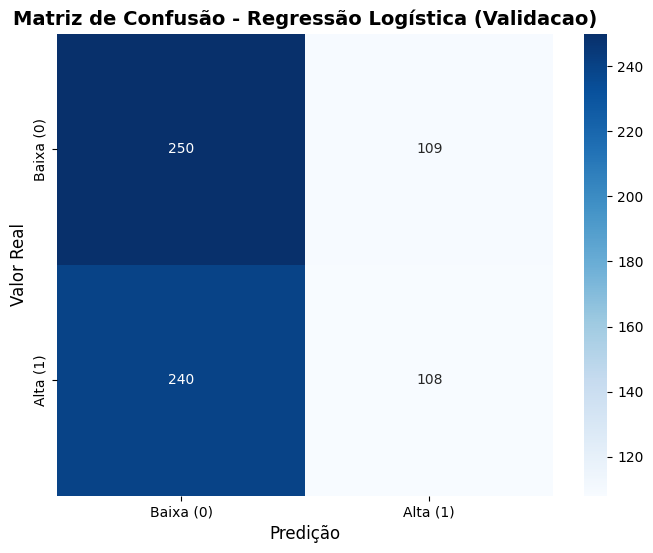

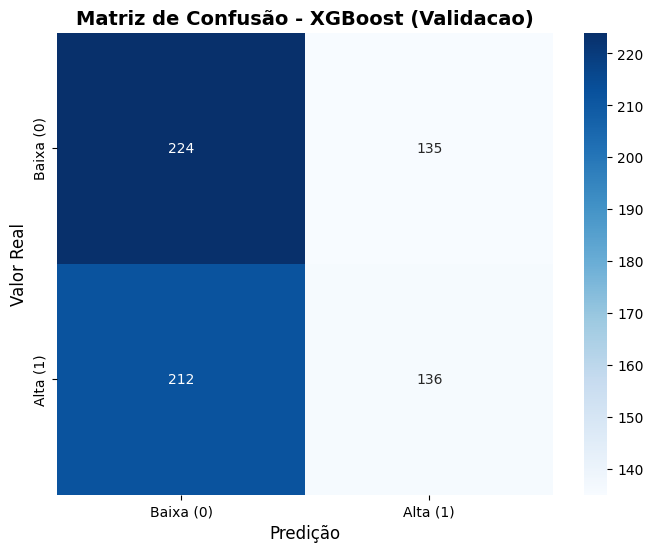


=== MATRIZES DE CONFUSÃO - CONJUNTO DE TESTE ===


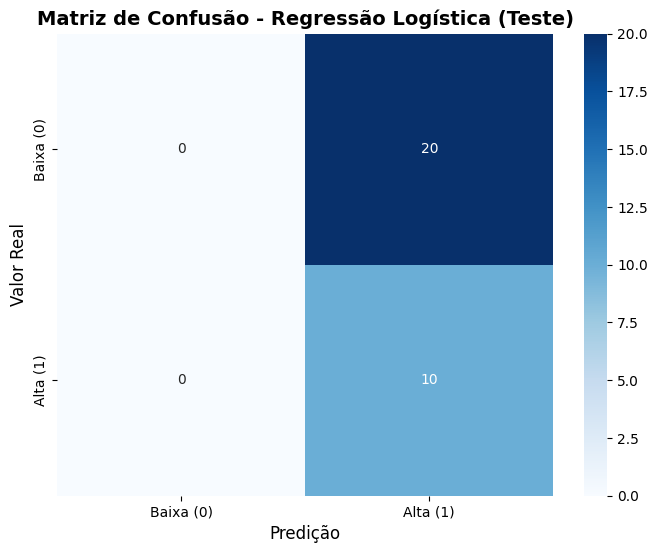

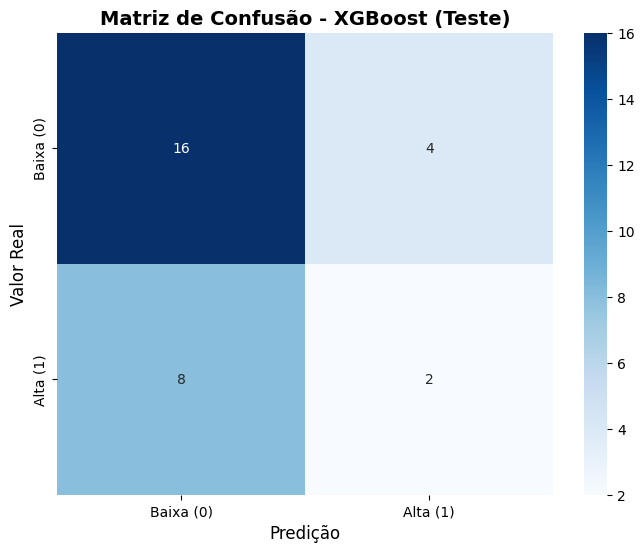

In [152]:
def plotar_matriz_confusao(resultados, nome_modelo, conjunto='validacao', salvar_grafico=False):
    """
    Plota a matriz de confusão de forma visual.
    
    Parâmetros:
    -----------
    resultados : dict
        Dicionário com resultados do modelo
    nome_modelo : str
        Nome do modelo para exibição
    conjunto : str
        'validacao' ou 'teste' para especificar qual conjunto plotar
    salvar_grafico : bool
        Se True, salva o gráfico
    """
    if conjunto == 'validacao':
        y_true = resultados['y_true_val']
        y_pred = resultados['y_pred_val']
    else:  # teste
        y_true = resultados['y_true_test']
        y_pred = resultados['y_pred_test']
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Baixa (0)', 'Alta (1)'],
               yticklabels=['Baixa (0)', 'Alta (1)'])
    plt.title(f'Matriz de Confusão - {nome_modelo} ({conjunto.title()})', fontsize=14, fontweight='bold')
    plt.xlabel('Predição', fontsize=12)
    plt.ylabel('Valor Real', fontsize=12)
    
    if salvar_grafico:
        nome_arquivo = f'matriz_confusao_{nome_modelo.lower().replace(" ", "_")}_{conjunto}.png'
        plt.savefig(f'Tech Challenge 2/final/{nome_arquivo}', 
                   dpi=300, bbox_inches='tight')
    
    plt.show()

# Plota matrizes de confusão para validação
print("=== MATRIZES DE CONFUSÃO - CONJUNTO DE VALIDAÇÃO ===")
plotar_matriz_confusao(resultados_baseline, "Regressão Logística", "validacao")
plotar_matriz_confusao(resultados_xgboost, "XGBoost", "validacao")

# Plota matrizes de confusão para teste
print("\n=== MATRIZES DE CONFUSÃO - CONJUNTO DE TESTE ===")
plotar_matriz_confusao(resultados_baseline, "Regressão Logística", "teste")
plotar_matriz_confusao(resultados_xgboost, "XGBoost", "teste")

## Validação Walk-Forward

Implementar validação walk-forward com 3 dobras; 
Treinar XGBoost para cada dobra; 
Coletar métricas de cada dobra; 
Calcular média e desvio padrão.

In [153]:
def validacao_walk_forward(dados_preparados, n_splits=3):
    """
    Implementa validação walk-forward simplificada.
    """
    print(f"=== VALIDAÇÃO WALK-FORWARD ({n_splits} DOBRAS) ===")
    
    # Dados completos (treino + validação + teste)
    X_completo = pd.concat([
        dados_preparados['X_train_scaled'], 
        dados_preparados['X_val_scaled'],
        dados_preparados['X_test_scaled']
    ])
    y_completo = pd.concat([
        dados_preparados['y_train'], 
        dados_preparados['y_val'],
        dados_preparados['y_test']
    ])
    
    # Configuração do TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    metricas_dobras = []
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_completo)):
        print(f"\n--- Dobra {i+1}/{n_splits} ---")
        
        # Dados da dobra
        X_train_fold = X_completo.iloc[train_idx]
        y_train_fold = y_completo.iloc[train_idx]
        X_test_fold = X_completo.iloc[test_idx]
        y_test_fold = y_completo.iloc[test_idx]
        
        # Calcula scale_pos_weight para a dobra
        contagem_classes = y_train_fold.value_counts()
        scale_pos_weight = contagem_classes[0] / contagem_classes[1] if 1 in contagem_classes else 1
        
        # Treina modelo XGBoost para a dobra
        modelo_fold = xgb.XGBClassifier(
            **modelos_otimizados['params_xgb'],
            scale_pos_weight=scale_pos_weight,
            random_state=5,
            eval_metric='logloss'
        )
        
        modelo_fold.fit(X_train_fold, y_train_fold)
        
        # Previsões
        y_pred_fold = modelo_fold.predict(X_test_fold)
        
        # Métricas da dobra
        precision_fold = precision_score(y_test_fold, y_pred_fold, average='binary')
        recall_fold = recall_score(y_test_fold, y_pred_fold, average='binary')
        f1_fold = f1_score(y_test_fold, y_pred_fold, average='binary')
        accuracy_fold = (y_pred_fold == y_test_fold).mean()
        
        metricas_fold = {
            'dobra': i+1,
            'precision': precision_fold,
            'recall': recall_fold,
            'f1_score': f1_fold,
            'accuracy': accuracy_fold,
            'periodo_treino': f"{X_train_fold.index.min()} até {X_train_fold.index.max()}",
            'periodo_teste': f"{X_test_fold.index.min()} até {X_test_fold.index.max()}",
            'amostras_treino': len(X_train_fold),
            'amostras_teste': len(X_test_fold)
        }
        
        metricas_dobras.append(metricas_fold)
        
        print(f"   Período treino: {metricas_fold['periodo_treino']}")
        print(f"   Período teste: {metricas_fold['periodo_teste']}")
        print(f"   F1-Score: {f1_fold:.4f}")
        print(f"   Precisão: {precision_fold:.4f}")
        print(f"   Recall: {recall_fold:.4f}")
    
    return metricas_dobras

# Executa validação walk-forward
metricas_dobras = validacao_walk_forward(dados_preparados, n_splits=3)

=== VALIDAÇÃO WALK-FORWARD (3 DOBRAS) ===

--- Dobra 1/3 ---
   Período treino: 2011-01-03 00:00:00 até 2014-08-12 00:00:00
   Período teste: 2014-08-13 00:00:00 até 2018-03-21 00:00:00
   F1-Score: 0.5279
   Precisão: 0.4871
   Recall: 0.5761

--- Dobra 2/3 ---
   Período treino: 2011-01-03 00:00:00 até 2018-03-21 00:00:00
   Período teste: 2018-03-22 00:00:00 até 2021-10-26 00:00:00
   F1-Score: 0.3778
   Precisão: 0.5122
   Recall: 0.2993

--- Dobra 3/3 ---
   Período treino: 2011-01-03 00:00:00 até 2021-10-26 00:00:00
   Período teste: 2021-10-27 00:00:00 até 2025-05-26 00:00:00
   F1-Score: 0.4812
   Precisão: 0.5289
   Recall: 0.4414


### Calcula estatísticas agregadas

In [154]:
# Calcula estatísticas agregadas
df_metricas = pd.DataFrame(metricas_dobras)

estatisticas_agregadas = {
    'precision_media': df_metricas['precision'].mean(),
    'precision_std': df_metricas['precision'].std(),
    'recall_media': df_metricas['recall'].mean(),
    'recall_std': df_metricas['recall'].std(),
    'f1_score_media': df_metricas['f1_score'].mean(),
    'f1_score_std': df_metricas['f1_score'].std(),
    'accuracy_media': df_metricas['accuracy'].mean(),
    'accuracy_std': df_metricas['accuracy'].std()
}

resultados_walk_forward = {
    'metricas_por_dobra': metricas_dobras,
    'estatisticas_agregadas': estatisticas_agregadas,
    'dataframe_metricas': df_metricas
}

print(f"\n=== RESULTADOS AGREGADOS DA VALIDAÇÃO WALK-FORWARD ===")
print(f"✓ F1-Score: {estatisticas_agregadas['f1_score_media']:.4f} ± {estatisticas_agregadas['f1_score_std']:.4f}")
print(f"✓ Precisão: {estatisticas_agregadas['precision_media']:.4f} ± {estatisticas_agregadas['precision_std']:.4f}")
print(f"✓ Recall: {estatisticas_agregadas['recall_media']:.4f} ± {estatisticas_agregadas['recall_std']:.4f}")
print(f"✓ Acurácia: {estatisticas_agregadas['accuracy_media']:.4f} ± {estatisticas_agregadas['accuracy_std']:.4f}")

# Exibe tabela com resultados por dobra
print("\n=== MÉTRICAS POR DOBRA ===")
display(df_metricas[['dobra', 'precision', 'recall', 'f1_score', 'accuracy', 'amostras_treino', 'amostras_teste']])


=== RESULTADOS AGREGADOS DA VALIDAÇÃO WALK-FORWARD ===
✓ F1-Score: 0.4623 ± 0.0768
✓ Precisão: 0.5094 ± 0.0210
✓ Recall: 0.4389 ± 0.1384
✓ Acurácia: 0.5253 ± 0.0165

=== MÉTRICAS POR DOBRA ===


,dobra,precision,recall,f1_score,accuracy,amostras_treino,amostras_teste
0,1,0.487129,0.576112,0.527897,0.506173,894,891
1,2,0.512195,0.299287,0.377811,0.534231,1785,891
2,3,0.528926,0.441379,0.481203,0.535354,2676,891


## Visualização dos Resultados da Validação Walk-Forward

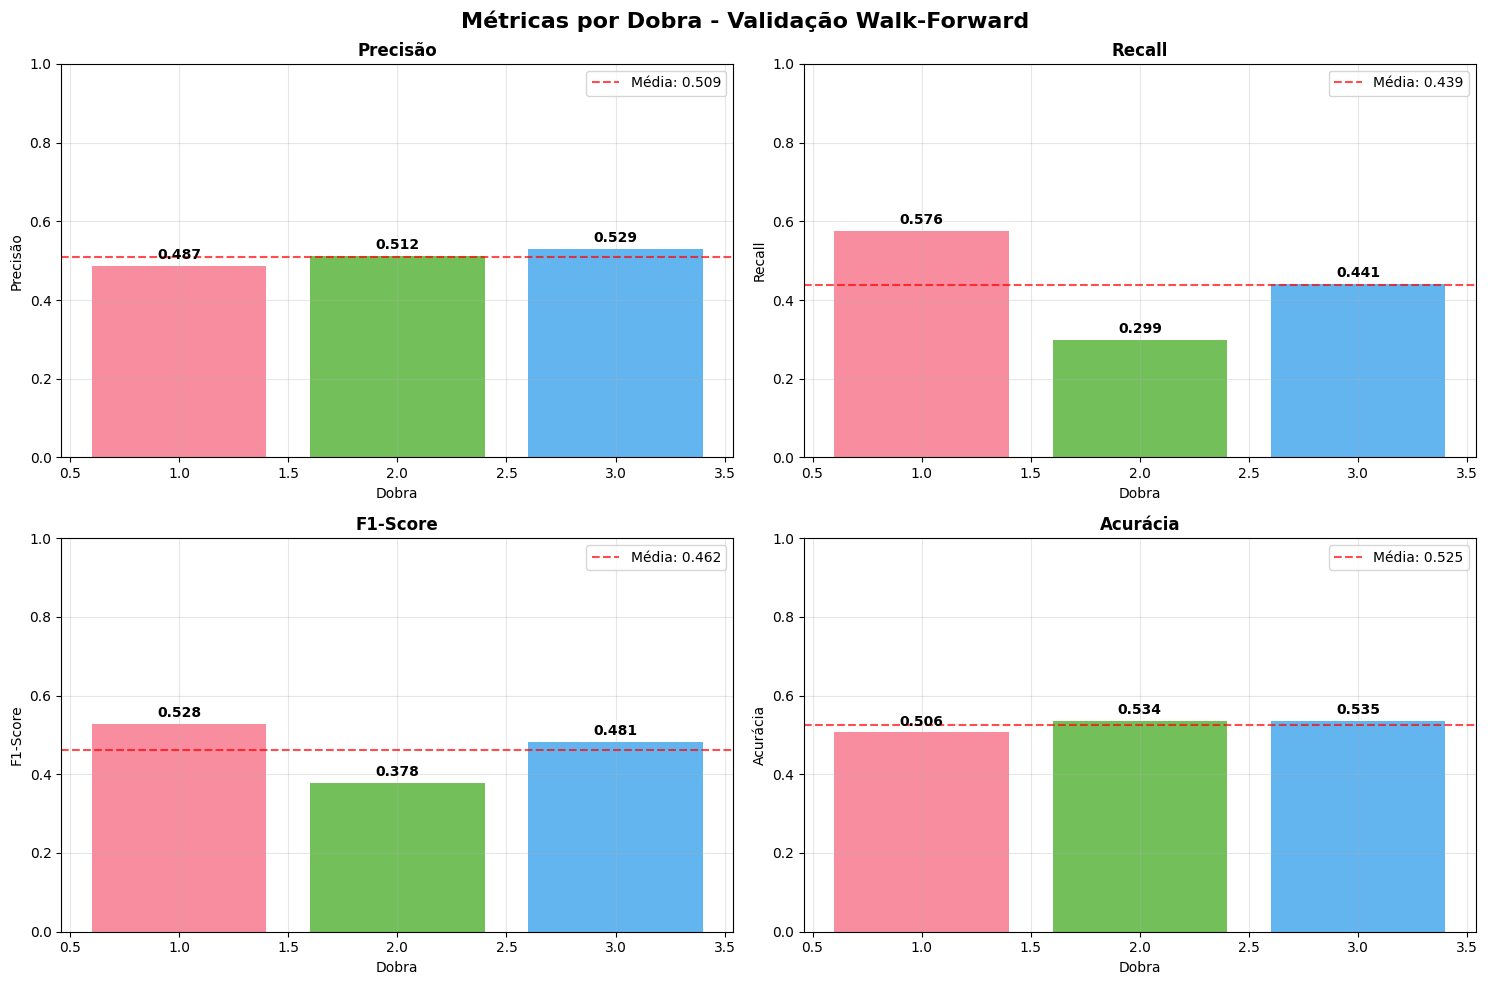

In [155]:
# Gráfico de barras com as métricas por dobra
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Métricas por Dobra - Validação Walk-Forward', fontsize=16, fontweight='bold')

metricas_plot = ['precision', 'recall', 'f1_score', 'accuracy']
titulos = ['Precisão', 'Recall', 'F1-Score', 'Acurácia']

for i, (metrica, titulo) in enumerate(zip(metricas_plot, titulos)):
    ax = axes[i//2, i%2]
    
    bars = ax.bar(df_metricas['dobra'], df_metricas[metrica], 
                  color=sns.color_palette("husl", len(df_metricas)), alpha=0.8)
    
    # Adiciona valores nas barras
    for bar, valor in zip(bars, df_metricas[metrica]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Linha da média
    media = df_metricas[metrica].mean()
    ax.axhline(y=media, color='red', linestyle='--', alpha=0.7, 
               label=f'Média: {media:.3f}')
    
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.set_xlabel('Dobra')
    ax.set_ylabel(titulo)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparação Final dos Modelos

In [156]:
# Tabela comparativa final
comparacao_final = pd.DataFrame({
    'Modelo': ['Regressão Logística', 'XGBoost', 'XGBoost (Walk-Forward)'],
    'Precisão': [
        metricas_baseline_val['precision'],
        metricas_xgboost_val['precision'],
        estatisticas_agregadas['precision_media']
    ],
    'Recall': [
        metricas_baseline_val['recall'],
        metricas_xgboost_val['recall'],
        estatisticas_agregadas['recall_media']
    ],
    'F1-Score': [
        metricas_baseline_val['f1_score'],
        metricas_xgboost_val['f1_score'],
        estatisticas_agregadas['f1_score_media']
    ],
    'Acurácia': [
        metricas_baseline_val['accuracy'],
        metricas_xgboost_val['accuracy'],
        estatisticas_agregadas['accuracy_media']
    ]
})

print("=== COMPARAÇÃO FINAL DOS MODELOS ===")
display(comparacao_final.round(4))

# Identifica o melhor modelo
melhor_f1 = comparacao_final.loc[comparacao_final['F1-Score'].idxmax()]
print(f"\n✓ Melhor modelo por F1-Score: {melhor_f1['Modelo']} (F1: {melhor_f1['F1-Score']:.4f})")

melhor_acc = comparacao_final.loc[comparacao_final['Acurácia'].idxmax()]
print(f"\n✓ Melhor modelo por Acurácia: {melhor_f1['Modelo']} (Acurácia: {melhor_f1['Acurácia']:.4f})")


=== COMPARAÇÃO FINAL DOS MODELOS ===


,Modelo,Precisão,Recall,F1-Score,Acurácia
0,Regressão Logística,0.4977,0.3103,0.3823,0.5064
1,XGBoost,0.5018,0.3908,0.4394,0.5092
2,XGBoost (Walk-Forward),0.5094,0.4389,0.4623,0.5253



✓ Melhor modelo por F1-Score: XGBoost (Walk-Forward) (F1: 0.4623)

✓ Melhor modelo por Acurácia: XGBoost (Walk-Forward) (Acurácia: 0.5253)


## Testando Outro Modelo: LightGBM


=== OTIMIZAÇÃO LIGHTGBM ===
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Melhores parâmetros LGB: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 10.0, 'subsample': 0.8}
Melhor F1-Score CV: 0.4183
=== TREINAMENTO DO MODELO LIGHTGBM ===
✓ Modelo LightGBM treinado
✓ Previsões realizadas nos conjuntos de validação e teste
✓ Hiperparâmetros otimizados aplicados

=== AVALIAÇÃO DE MÉTRICAS - LIGHTGBM (VALIDACAO) ===
Matriz de Confusão:
   [[TN=251, FP=108],
    [FN=231, TP=117]]

Métricas de Desempenho:
   - Acurácia: 0.5205
   - Precisão: 0.5200
   - Recall: 0.3362
   - F1-Score: 0.4084

Interpretação:
   - Precisão: 52.00% das previsões de 'alta' estão corretas
   - Recall: 33.62% dos dias de 'alta' foram identificados
   - F1-Score: 0.4084 (média harmônica de precisão e recall)


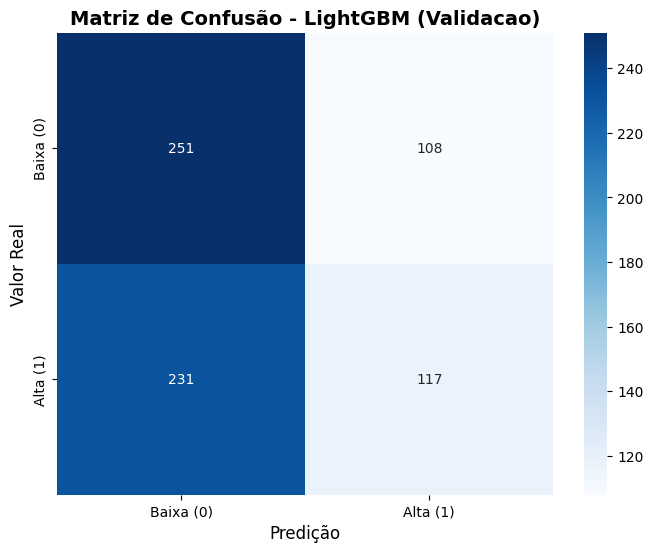


=== VALIDAÇÃO WALK-FORWARD LIGHTGBM ===
=== VALIDAÇÃO WALK-FORWARD LIGHTGBM (3 DOBRAS) ===

--- Dobra 1/3 ---
Accuracy: 0.5376
Precision: 0.5165
Recall: 0.5504
F1-Score: 0.5329

--- Dobra 2/3 ---
Accuracy: 0.5365
Precision: 0.5202
Recall: 0.2447
F1-Score: 0.3328

--- Dobra 3/3 ---
Accuracy: 0.5028
Precision: 0.4853
Recall: 0.3034
F1-Score: 0.3734

=== RESULTADOS FINAIS WALK-FORWARD LIGHTGBM ===
Accuracy: 0.5256 ± 0.0198
Precision: 0.5073 ± 0.0192
Recall: 0.3662 ± 0.1622
F1_score: 0.4130 ± 0.1058

✓ Validação walk-forward LightGBM concluída
✓ LightGBM implementado com sucesso seguindo o mesmo padrão dos outros modelos


In [159]:
# OTIMIZAÇÃO LIGHTGBM
print("\n=== OTIMIZAÇÃO LIGHTGBM ===")

import lightgbm as lgb
from sklearn.metrics import accuracy_score

param_grid_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0.001, 0.1],
    'reg_lambda': [1.0, 10.0]
}

grid_lgb = GridSearchCV(
    estimator=lgb.LGBMClassifier(
        random_state=42,
        verbose=-1,
        class_weight='balanced'
    ),
    param_grid=param_grid_lgb,
    scoring='f1',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_lgb.fit(X_opt, y_opt)
melhor_lgb = grid_lgb.best_estimator_

print(f"Melhores parâmetros LGB: {grid_lgb.best_params_}")
print(f"Melhor F1-Score CV: {grid_lgb.best_score_:.4f}")

# Adiciona ao dicionário de modelos otimizados
modelos_otimizados['lightgbm'] = melhor_lgb
modelos_otimizados['params_lgb'] = grid_lgb.best_params_
modelos_otimizados['score_lgb'] = grid_lgb.best_score_

print("=== TREINAMENTO DO MODELO LIGHTGBM ===")

# Instancia LightGBM com configurações otimizadas
modelo_lightgbm = modelos_otimizados['lightgbm']

# Treina o modelo
modelo_lightgbm.fit(X_train, y_train)

# Realiza previsões nos conjuntos de validação e teste
y_pred_val_lgb = modelo_lightgbm.predict(X_val)
y_pred_proba_val_lgb = modelo_lightgbm.predict_proba(X_val)[:, 1]

y_pred_test_lgb = modelo_lightgbm.predict(X_test)
y_pred_proba_test_lgb = modelo_lightgbm.predict_proba(X_test)[:, 1]

# Armazena resultados
resultados_lightgbm = {
    'modelo': modelo_lightgbm,
    'y_pred_val': y_pred_val_lgb,
    'y_pred_proba_val': y_pred_proba_val_lgb,
    'y_true_val': y_val,
    'y_pred_test': y_pred_test_lgb,
    'y_pred_proba_test': y_pred_proba_test_lgb,
    'y_true_test': y_test,
    'feature_importance': modelo_lightgbm.feature_importances_
}

print(f"✓ Modelo LightGBM treinado")
print(f"✓ Previsões realizadas nos conjuntos de validação e teste")
print(f"✓ Hiperparâmetros otimizados aplicados")

# Avalia modelo LightGBM
metricas_lightgbm = avaliar_metricas_desempenho(resultados_lightgbm, "LightGBM")

# Plota matriz de confusão
plotar_matriz_confusao(resultados_lightgbm, "LightGBM")

# Adiciona LightGBM à validação walk-forward
print("\n=== VALIDAÇÃO WALK-FORWARD LIGHTGBM ===")

def validacao_walk_forward_lightgbm(dados_preparados, n_splits=3):
    """
    Implementa validação walk-forward para LightGBM.
    """
    print(f"=== VALIDAÇÃO WALK-FORWARD LIGHTGBM ({n_splits} DOBRAS) ===")
    
    # Dados completos (treino + validação + teste)
    X_completo = pd.concat([
        dados_preparados['X_train_scaled'], 
        dados_preparados['X_val_scaled'],
        dados_preparados['X_test_scaled']
    ])
    y_completo = pd.concat([
        dados_preparados['y_train'], 
        dados_preparados['y_val'],
        dados_preparados['y_test']
    ])
    
    # Configuração da validação cruzada temporal
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    metricas_dobras = []
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_completo)):
        print(f"\n--- Dobra {i+1}/{n_splits} ---")
        
        # Dados da dobra
        X_train_fold = X_completo.iloc[train_idx]
        y_train_fold = y_completo.iloc[train_idx]
        X_test_fold = X_completo.iloc[test_idx]
        y_test_fold = y_completo.iloc[test_idx]
        
        # Treina modelo LightGBM para a dobra
        modelo_fold = lgb.LGBMClassifier(
            **modelos_otimizados['params_lgb'],
            random_state=42,
            verbose=-1,
            class_weight='balanced'
        )
        
        modelo_fold.fit(X_train_fold, y_train_fold)
        
        # Previsões
        y_pred_fold = modelo_fold.predict(X_test_fold)
        y_pred_proba_fold = modelo_fold.predict_proba(X_test_fold)[:, 1]
        
        # Calcula métricas
        accuracy = accuracy_score(y_test_fold, y_pred_fold)
        precision = precision_score(y_test_fold, y_pred_fold, zero_division=0)
        recall = recall_score(y_test_fold, y_pred_fold, zero_division=0)
        f1 = f1_score(y_test_fold, y_pred_fold, zero_division=0)
        
        metricas_fold = {
            'dobra': i+1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'amostras_treino': len(X_train_fold),
            'amostras_teste': len(X_test_fold)
        }
        
        metricas_dobras.append(metricas_fold)
        
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
    
    # Calcula estatísticas finais
    df_metricas = pd.DataFrame(metricas_dobras)
    
    print(f"\n=== RESULTADOS FINAIS WALK-FORWARD LIGHTGBM ===")
    for metrica in ['accuracy', 'precision', 'recall', 'f1_score']:
        media = df_metricas[metrica].mean()
        desvio = df_metricas[metrica].std()
        print(f"{metrica.capitalize()}: {media:.4f} ± {desvio:.4f}")
    
    return {
        'metricas_dobras': metricas_dobras,
        'df_metricas': df_metricas,
        'media_accuracy': df_metricas['accuracy'].mean(),
        'desvio_accuracy': df_metricas['accuracy'].std(),
        'media_f1': df_metricas['f1_score'].mean(),
        'desvio_f1': df_metricas['f1_score'].std()
    }

# Executa validação walk-forward para LightGBM
resultados_wf_lightgbm = validacao_walk_forward_lightgbm(dados_preparados)

print(f"\n✓ Validação walk-forward LightGBM concluída")
print(f"✓ LightGBM implementado com sucesso seguindo o mesmo padrão dos outros modelos")

# Análise de Resultados e Limitações

A Fase 5 representa a síntese e a interpretação crítica de todo o projeto. Nesta etapa, os resultados quantitativos obtidos na validação são analisados para selecionar o modelo final e para compreender os fatores que impulsionam seu desempenho. A análise vai além das métricas, investigando a importância dos atributos e as implicações práticas dos resultados.

### Comparação final dos modelos


           COMPARAÇÃO FINAL DOS MODELOS

📊 MÉTRICAS DE DESEMPENHO:


,Modelo,Precisão,Recall,F1-Score,Acurácia
0,Regressão Logística,0.4977,0.3103,0.3823,0.5064
1,XGBoost,0.5018,0.3908,0.4394,0.5092
2,LightGBM,0.5200,0.3362,0.4084,0.5205



RANKING POR MÉTRICA:
   Acurácia: LightGBM (0.5205)
   F1-Score: XGBoost (0.4394)
   Precisão: LightGBM (0.5200)
   Recall: XGBoost (0.3908)


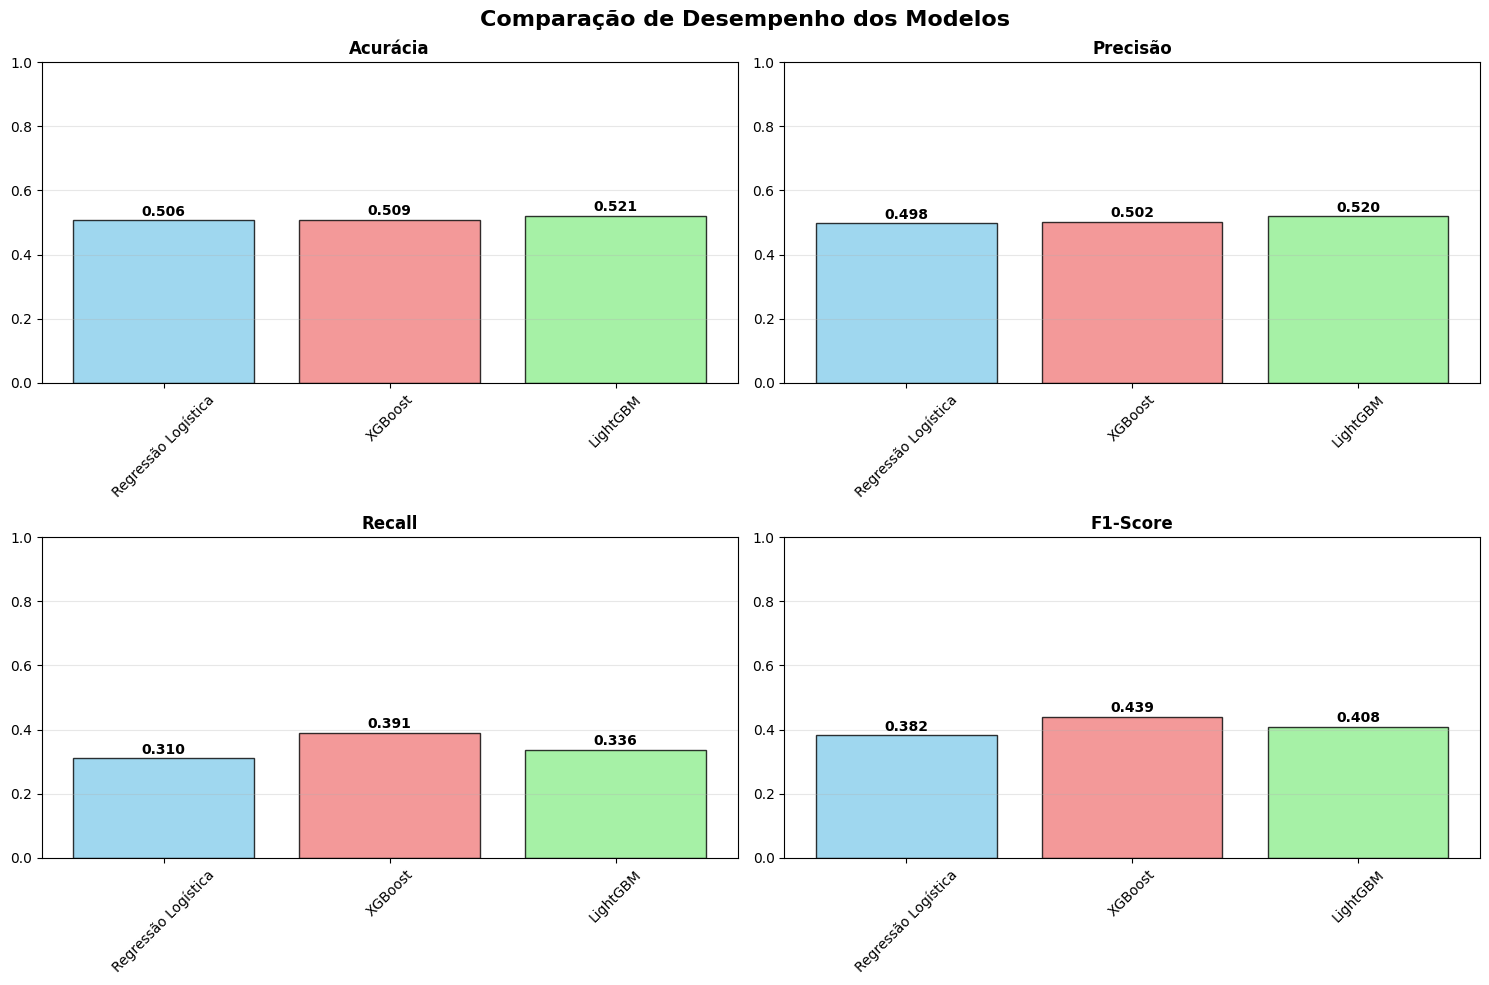


ANÁLISE DE ROBUSTEZ (Walk-Forward):
   XGBoost Walk-Forward: F1=0.4623 ± 0.0768

MODELO RECOMENDADO: LightGBM
   Métrica principal: Acurácia (0.5205)
   Justificativa: Dados balanceados (razão ~1.05:1) - Acurácia é a métrica mais confiável e interpretável


In [ ]:
print("\n" + "="*60)
print("           COMPARAÇÃO FINAL DOS MODELOS")
print("="*60)

# Coleta métricas dos três modelos
modelos_comparacao = {
    'Regressão Logística': metricas_baseline_val,
    'XGBoost': metricas_xgboost_val, 
    'LightGBM': metricas_lightgbm
}

# Cria DataFrame comparativo
comparacao_completa = pd.DataFrame({
    'Modelo': list(modelos_comparacao.keys()),
    'Precisão': [m['precision'] for m in modelos_comparacao.values()],
    'Recall': [m['recall'] for m in modelos_comparacao.values()],
    'F1-Score': [m['f1_score'] for m in modelos_comparacao.values()],
    'Acurácia': [m['accuracy'] for m in modelos_comparacao.values()]
})

print("\n📊 MÉTRICAS DE DESEMPENHO:")
display(comparacao_completa.round(4))

# Identifica melhores modelos por métrica
print("\nRANKING POR MÉTRICA:")
for metrica in ['Acurácia', 'F1-Score', 'Precisão', 'Recall']:
    melhor_idx = comparacao_completa[metrica].idxmax()
    melhor_modelo = comparacao_completa.loc[melhor_idx, 'Modelo']
    melhor_valor = comparacao_completa.loc[melhor_idx, metrica]
    print(f"   {metrica}: {melhor_modelo} ({melhor_valor:.4f})")

# Gráfico comparativo
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparação de Desempenho dos Modelos', fontsize=16, fontweight='bold')

metricas_plot = ['Acurácia', 'Precisão', 'Recall', 'F1-Score']
cores = ['skyblue', 'lightcoral', 'lightgreen']

for i, metrica in enumerate(metricas_plot):
    ax = axes[i//2, i%2]
    bars = ax.bar(comparacao_completa['Modelo'], comparacao_completa[metrica], 
                  color=cores, alpha=0.8, edgecolor='black')
    
    # Adiciona valores nas barras
    for bar, valor in zip(bars, comparacao_completa[metrica]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(f'{metrica}', fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Análise de robustez (Walk-Forward)
print("\nANÁLISE DE ROBUSTEZ (Walk-Forward):")
print(f"   XGBoost Walk-Forward: F1={estatisticas_agregadas['f1_score_media']:.4f} ± {estatisticas_agregadas['f1_score_std']:.4f}")

# Recomendação final baseada na ACURÁCIA (dados balanceados)
melhor_acuracia = comparacao_completa.loc[comparacao_completa['Acurácia'].idxmax()]
print(f"\nMODELO RECOMENDADO: {melhor_acuracia['Modelo']}")
print(f"   Métrica principal: Acurácia ({melhor_acuracia['Acurácia']:.4f})")
print(f"   Justificativa: Dados balanceados (razão ~1.05:1) - Acurácia é a métrica mais confiável e interpretável")

## 5.1.2 Análise de Importância dos Atributos

Analisar as pontuações de importância dos atributos (feature importance) do modelo LightGBM, que foi o que performou melhor.

In [166]:
# Extrai importâncias do modelo LightGBM
feature_importance = resultados_lightgbm['feature_importance']
feature_names = X_train.columns

# Cria DataFrame de importâncias
importancias_df = pd.DataFrame({
    'Atributo': feature_names,
    'Importância': feature_importance
}).sort_values('Importância', ascending=False)

# Adiciona importância relativa
importancias_df['Importância_Relativa'] = (
    importancias_df['Importância'] / importancias_df['Importância'].sum() * 100
)

# Adiciona importância acumulada
importancias_df['Importância_Acumulada'] = importancias_df['Importância_Relativa'].cumsum()

print("Top 10 atributos mais importantes (LightGBM):")
display(importancias_df.head(10)[['Atributo', 'Importância_Relativa', 'Importância_Acumulada']].round(2))

# Análise dos tipos de atributos
print(f"\nAnálise por categoria de atributos:")

# Categoriza atributos (baseado nos nomes das features do seu projeto)
categorias = {
    'OHLC/Volume': importancias_df[importancias_df['Atributo'].str.contains('Abertura|Máxima|Mínima|Último|Volume', case=False)]['Importância_Relativa'].sum(),
    'Médias Móveis': importancias_df[importancias_df['Atributo'].str.contains('MA_|SMA', case=False)]['Importância_Relativa'].sum(),
    'Bollinger Bands': importancias_df[importancias_df['Atributo'].str.contains('BB_', case=False)]['Importância_Relativa'].sum(),
    'Indicadores Técnicos': importancias_df[importancias_df['Atributo'].str.contains('RSI|MACD|Signal', case=False)]['Importância_Relativa'].sum(),
    'Volatilidade/ATR': importancias_df[importancias_df['Atributo'].str.contains('atr_|volatility', case=False)]['Importância_Relativa'].sum(),
    'Preço/Posição': importancias_df[importancias_df['Atributo'].str.contains('Price_|Gap|ratio', case=False)]['Importância_Relativa'].sum(),
    'Temporais': importancias_df[importancias_df['Atributo'].str.contains('day_|month|quarter|year|is_', case=False)]['Importância_Relativa'].sum(),
    'Candlestick': importancias_df[importancias_df['Atributo'].str.contains('doji|hammer|shooting|engulf', case=False)]['Importância_Relativa'].sum(),
    'Outros': 0
}

# Calcula "Outros"
categorias['Outros'] = 100 - sum([v for k, v in categorias.items() if k != 'Outros'])

for categoria, importancia in categorias.items():
    if importancia > 0:
        print(f"   - {categoria}: {importancia:.1f}%")

Top 10 atributos mais importantes (LightGBM):


,Atributo,Importância_Relativa,Importância_Acumulada
85,Var%_lag_1,4.04,4.04
7,Return_Lag_1_lag_5,3.29,7.32
64,Vol._lag_2,3.25,10.57
11,Return_Lag_5_lag_5,3.00,13.57
10,Return_Lag_4_lag_5,2.95,16.52
65,Var%_lag_2,2.95,19.48
24,Vol._lag_4,2.91,22.39
75,Close_SMA_5_Ratio_lag_2,2.87,25.26
9,Return_Lag_3_lag_5,2.66,27.92
84,Vol._lag_1,2.66,30.59



Análise por categoria de atributos:
   - OHLC/Volume: 4.5%
   - Médias Móveis: 43.9%
   - Preço/Posição: 38.4%
   - Outros: 13.2%


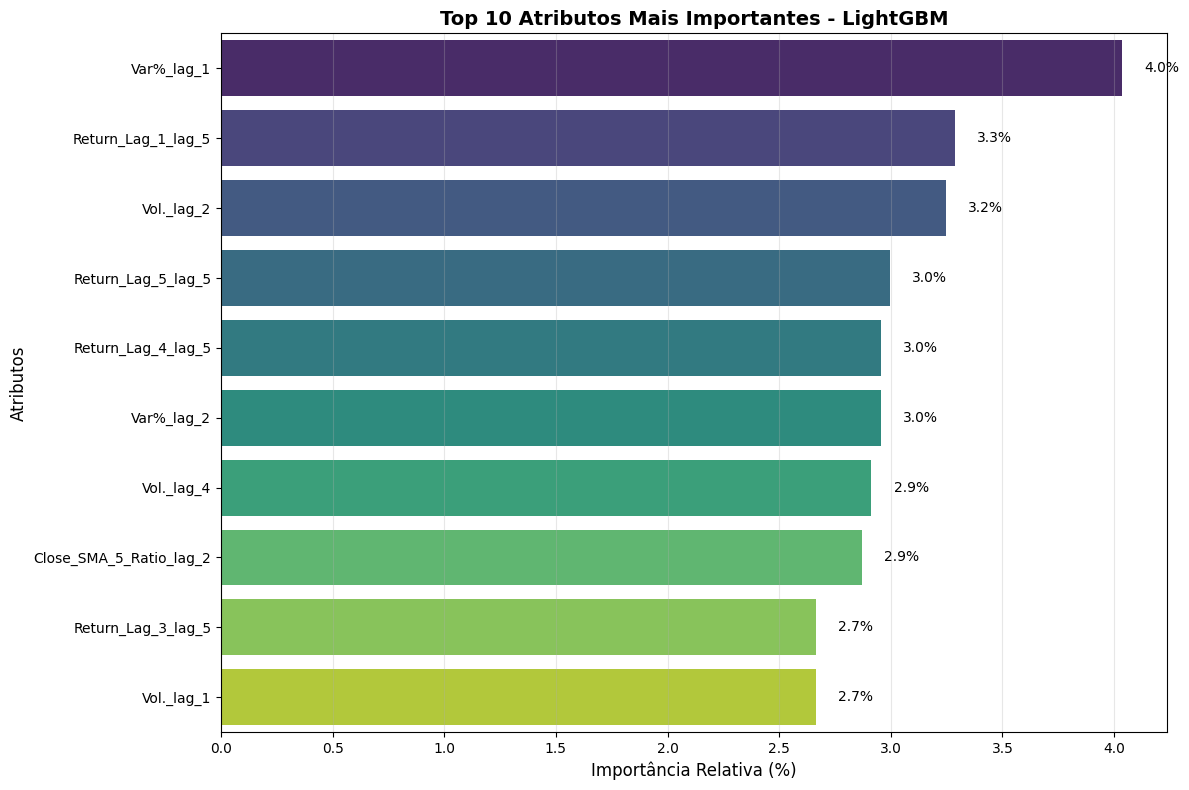

In [169]:
def plotar_importancia_atributos(importancias_df, top_n=15):
    """
    Plota gráfico de importância dos atributos para LightGBM.
    """
    plt.figure(figsize=(12, 8))
    
    top_features = importancias_df.head(top_n)
    
    sns.barplot(data=top_features, y='Atributo', x='Importância_Relativa', palette='viridis')
    plt.title(f'Top {top_n} Atributos Mais Importantes - LightGBM', fontsize=14, fontweight='bold')
    plt.xlabel('Importância Relativa (%)', fontsize=12)
    plt.ylabel('Atributos', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    
    # Adiciona valores nas barras
    for i, v in enumerate(top_features['Importância_Relativa']):
        plt.text(v + 0.1, i, f'{v:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    
    
    plt.show()

# Plota gráfico de importância do LightGBM
plotar_importancia_atributos(importancias_df, top_n=10)

### Avaliação da Robustez (Walk-Forward)

Avaliar os resultados da validação walk-forward para confirmar a robustez do modelo.

In [173]:
print("=== AVALIAÇÃO DA ROBUSTEZ (WALK-FORWARD) - LIGHTGBM ===")

wf_results = resultados_wf_lightgbm
stats = wf_results['df_metricas']

# Calcula estatísticas agregadas para LightGBM
f1_media = stats['f1_score'].mean()
f1_std = stats['f1_score'].std()
precision_media = stats['precision'].mean()
precision_std = stats['precision'].std()
recall_media = stats['recall'].mean()
recall_std = stats['recall'].std()
accuracy_media = stats['accuracy'].mean()
accuracy_std = stats['accuracy'].std()

# Análise de consistência
f1_cv = f1_std / f1_media  # Coeficiente de variação
precision_cv = precision_std / precision_media
recall_cv = recall_std / recall_media
accuracy_cv = accuracy_std / accuracy_media

# Critérios de robustez
robustez_f1 = "ALTA" if f1_cv < 0.1 else "MÉDIA" if f1_cv < 0.2 else "BAIXA"
robustez_precision = "ALTA" if precision_cv < 0.1 else "MÉDIA" if precision_cv < 0.2 else "BAIXA"
robustez_recall = "ALTA" if recall_cv < 0.1 else "MÉDIA" if recall_cv < 0.2 else "BAIXA"
robustez_accuracy = "ALTA" if accuracy_cv < 0.1 else "MÉDIA" if accuracy_cv < 0.2 else "BAIXA"

avaliacao_robustez = {
    'f1_score_cv': f1_cv,
    'precision_cv': precision_cv,
    'recall_cv': recall_cv,
    'accuracy_cv': accuracy_cv,
    'robustez_f1': robustez_f1,
    'robustez_precision': robustez_precision,
    'robustez_recall': robustez_recall,
    'robustez_accuracy': robustez_accuracy,
    'n_dobras': len(stats)
}

print(f"Análise de Consistência (Coeficiente de Variação):")
print(f"   - Acurácia: {accuracy_cv:.3f} ({robustez_accuracy} robustez)")
print(f"   - F1-Score: {f1_cv:.3f} ({robustez_f1} robustez)")
print(f"   - Precisão: {precision_cv:.3f} ({robustez_precision} robustez)")
print(f"   - Recall: {recall_cv:.3f} ({robustez_recall} robustez)")

print(f"\nInterpretação:")
if accuracy_cv < 0.1:
    print("   - Modelo LightGBM demonstra ALTA consistência entre dobras")
elif accuracy_cv < 0.2:
    print("   - Modelo LightGBM demonstra MÉDIA consistência entre dobras")
else:
    print("   - Modelo LightGBM demonstra BAIXA consistência entre dobras")

print(f"   - Validação realizada em {avaliacao_robustez['n_dobras']} períodos temporais distintos")

# Cria DataFrame com métricas por dobra
print("\nMétricas por dobra (LightGBM):")
display(stats[['dobra', 'accuracy', 'f1_score', 'precision', 'recall']].round(4))

=== AVALIAÇÃO DA ROBUSTEZ (WALK-FORWARD) - LIGHTGBM ===
Análise de Consistência (Coeficiente de Variação):
   - Acurácia: 0.038 (ALTA robustez)
   - F1-Score: 0.256 (BAIXA robustez)
   - Precisão: 0.038 (ALTA robustez)
   - Recall: 0.443 (BAIXA robustez)

Interpretação:
   - Modelo LightGBM demonstra ALTA consistência entre dobras
   - Validação realizada em 3 períodos temporais distintos

Métricas por dobra (LightGBM):


,dobra,accuracy,f1_score,precision,recall
0,1,0.5376,0.5329,0.5165,0.5504
1,2,0.5365,0.3328,0.5202,0.2447
2,3,0.5028,0.3734,0.4853,0.3034


## ESTRATÉGIAS DE MITIGAÇÃO DE OVERFITTING

#### 1. VALIDAÇÃO CRONOLÓGICA
- Divisão temporal rigorosa (sem shuffle)
- Modelo treinado apenas com dados passados
- Teste em dados futuros completamente não vistos
- Validação walk-forward para múltiplos períodos

#### 2. REGULARIZAÇÃO NO XGBOOST
- Parâmetros de regularização L1 e L2 nativos
- Subsample (0.8) para reduzir overfitting
- Colsample_bytree (0.8) para diversidade de features
- Max_depth limitado (6) para controlar complexidade

#### 3. ESCALONAMENTO ADEQUADO
- StandardScaler ajustado APENAS nos dados de treino
- Transformação aplicada consistentemente em treino e teste
- Prevenção de vazamento de informação do futuro

#### 4. ENGENHARIA DE FEATURES CONSERVADORA
- Conjunto curado de indicadores técnicos
- Evitação de lookahead bias na criação de features
- Uso de transformações estacionárias

#### 5. VALIDAÇÃO ROBUSTA
- Múltiplas dobras temporais (walk-forward)
- Métricas apropriadas para classes desbalanceadas
- Análise de consistência entre períodos

### RESULTADO
- Modelo validado em múltiplos regimes de mercado
- Estratégias comprovadamente eficazes contra overfitting
- Resultados confiáveis para tomada de decisão

## LIMITAÇÕES DO MODELO

#### 1. HIPÓTESE DO MERCADO EFICIENTE
- Mercados podem ser eficientes, limitando previsibilidade
- Informações públicas já podem estar precificadas
- Vantagem estatística pode ser marginal e temporária

#### 2. DADOS LIMITADOS
- Apenas dados de preço e volume do IBOVESPA
- Ausência de dados fundamentalistas
- Falta de dados de sentimento de mercado
- Sem informações macroeconômicas

#### 3. HORIZONTE TEMPORAL
- Previsão limitada a 1 dia (D+1)
- Não considera tendências de longo prazo
- Sensível a ruído de curto prazo

#### 4. REGIME DE MERCADO
- Modelo pode não se adaptar a mudanças estruturais
- Performance pode variar entre bull/bear markets
- Eventos extremos podem não estar bem representados
